# **Exercise 04 - XGBoost**
### Laboratory of **Computational Physics**, module B
#### University of **Padua** *AY 2021/2022* 

### Group **02**
#### *Students:* Barone Francesco Pio, Nagaro Quiroz Gianmarco, Ninni Daniele, Valentini Lorenzo

***

In this notebook:

1) [CNN vs XGBoost in small dataset limit](#sec1)
2) [feature selection & description](#sec2)
3) [FFNN vs XGBoost](#sec3)
    - [FFNN on 11 selected features](#sec3_01)
    - [FFNN on 19 selected features](#sec3_02)
    - [Results](#sec3_res)
4) [XGBoost hyperparameter tuning with GridSearchCV](#sec4)
    - [Results](#sec4_01)
***

### **0** - setup

In [1]:
# place here all the imports you need
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
import plotly.graph_objects as go
import plotly.express as px
import seaborn

try:
    import cayde_env # importing a custom environment for my server
    cayde_env.tensorflow('CPU')
except: print('no need of custom environment')

from tsfresh import extract_features
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import tensorflow as tf
import tensorflow.random as tf_r
import keras, sklearn
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
print("\nXGBoost version:",xgboost.__version__)
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree


from IPython.display import display

# random seed 
np.random.seed(12345)

 [ CAYDE computing env ]
[tf] CPU set
XGBoost version: 1.5.2


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# select parts of the notebook to execute
do_generate_data = False
do_gridsearch = False
do_compute_features = False

In [3]:
# default folders
folder_data = 'DATA'
folder_img = 'img'

savefigs = True

<a id='sec1'></a>
## **1** - CNN vs XGBoost in small dataset limit

#### Definition of all the necessary functions

In [4]:
%run data_management_funcs.py

#### Generation of the dataset: just once

In [5]:
data_strain_param = {'dim':1, 'Z':12, 'A':500, 'N':10000, 'L':60, 'DX':50, 'bias':5}

if do_generate_data:
    x,y = create_strains_dataset(**data_strain_param)
    show_data_strains(x,data_strain_param['L'],"sample_strains",nsegments=6)  # <- this function has been changed w.r.t. the original one!
    saver(x,y,**data_strain_param)

#### Load data from the dataset

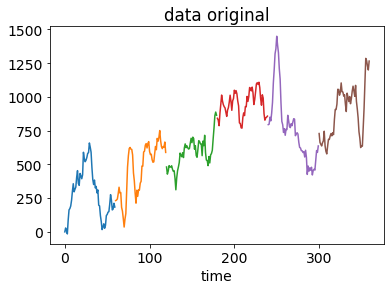

In [6]:
selected_strain_dataset = f'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex = f'{folder_data}/x_'+selected_strain_dataset
fnamey = f'{folder_data}/y_'+selected_strain_dataset

x = np.loadtxt(fnamex,delimiter=" ",dtype=float)
locals().update(data_strain_param)

categ = np.loadtxt(fnamey,dtype=int)
n_class = 3 # y.argmax()-y.argmin()+1

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

x = x.reshape((N,L,dim))
show_data_strains(x,L,"data original",nsegments=6)



#### Rescaling the data

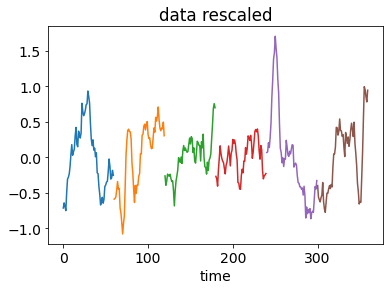

N_train= 8000   N_val= 2000   L= 60   n_class= 3


In [7]:
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

# SECOND PASSAGE: DO NOT DO THIS --> ALSO FAILURE 
#
# rescale (crude version, variance should be used)
x = x/400
    
show_data_strains(x,L,"data rescaled",nsegments=6)

perc_train = 0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

#x_train = x_train.astype("float32")
#y_train = y_train.astype("float32")
#x_val = x_val.astype("float32")
#y_val = y_val.astype("float32")

x_train = x_train.reshape(x_train.shape[0],L,1)
x_val = x_val.reshape(x_val.shape[0],L,1)


#### Defining a CNN model with convolutions and poolings

In [8]:
np.random.seed(12345)
tf_r.set_seed(12345)

reg = tf.keras.regularizers.l2(0.2)
ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
input_shape = (L, 1)

NCONV = 1
NF = 5

model = Sequential()
    
model.add(Conv1D(filters=NF, kernel_size=11, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation="relu", 
                     input_shape=input_shape))
model.add(AveragePooling1D(5))
model.add(Conv1D(filters=5, kernel_size=7, 
                     activation="relu"))
model.add(Flatten())
model.add(Dense(12, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(n_class, activation="sigmoid"))

print('----- Model',NCONV,'-----')
print(model.summary())

opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False,
                                               label_smoothing=0.0,
                                               axis=-1,
                                               reduction="auto",
                                               name="categorical_crossentropy",)

model.compile(loss=loss, optimizer=opt,metrics=['accuracy'])

----- Model 1 -----
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 5)             60        
                                                                 
 average_pooling1d (AverageP  (None, 10, 5)            0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 5)              180       
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 12)                252       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                    

2022-04-02 14:51:25.152011: E tensorflow/stream_executor/rocm/rocm_driver.cc:993] could not retrieve ROCM device count: HIP_ERROR_NoDevice
2022-04-02 14:51:25.152695: E tensorflow/stream_executor/rocm/rocm_driver.cc:993] could not retrieve ROCM device count: HIP_ERROR_NoDevice


In [9]:
model.layers

#### Training the basic CNN model, 10 times for each different size of the dataset.

In [10]:
dataset_sizes = np.array([20, 50, 100, 150, 200, 250, 300, 400, 500])
batch_sizes = [20, 50, 100, 150, 200, 250, 300, 400, 500]
epochs = [50, 50, 50, 50, 50, 50, 50, 50, 50]
basic_model_fits_complete = []
print('-----\nFITTING....')
for i in range(0,9):
    basic_model_fits = []
    for j in range (0,10):
        dataset_train_sizes = dataset_sizes*perc_train
        dataset_val_sizes = dataset_sizes*(1-perc_train)
        starting_point_train =  random.random_integers(low = 1, high = int(x_train.shape[0]-dataset_train_sizes[i])-1, size=None)
        starting_point_val =  random.random_integers(low = 1, high = int(x_val.shape[0]-dataset_val_sizes[i])-1, size=None)

        x_train_reduced = x_train[int(starting_point_train):int(starting_point_train+dataset_train_sizes[i]),:,:]
        x_val_reduced = x_val[int(starting_point_val):int(starting_point_val+dataset_val_sizes[i]),:,:]
        y_train_reduced = y_train[int(starting_point_train):int(starting_point_train+dataset_train_sizes[i]),:]
        y_val_reduced = y_val[int(starting_point_val):int(starting_point_val+dataset_val_sizes[i]),:]

        history = model.fit(x_train_reduced, y_train_reduced,
                                batch_size=batch_sizes[i],
                                epochs=epochs[i],
                                validation_data=(x_val_reduced, y_val_reduced),
                                verbose=2,
                                shuffle=True)
        basic_model_fits.append([history.history['accuracy'][-1], history.history['val_accuracy'][-1]])
    basic_model_fits_complete.append(basic_model_fits)


/tmp/ipykernel_345903/2149279362.py:11: DeprecationWarning: This function is deprecated. Please call randint(1, 7983 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = int(x_train.shape[0]-dataset_train_sizes[i])-1, size=None)
/tmp/ipykernel_345903/2149279362.py:12: DeprecationWarning: This function is deprecated. Please call randint(1, 1995 + 1) instead
  starting_point_val =  random.random_integers(low = 1, high = int(x_val.shape[0]-dataset_val_sizes[i])-1, size=None)


-----
FITTING....
Epoch 1/50
1/1 - 0s - loss: 1.1283 - accuracy: 0.3125 - val_loss: 1.1196 - val_accuracy: 0.5000 - 338ms/epoch - 338ms/step
Epoch 2/50
1/1 - 0s - loss: 1.1291 - accuracy: 0.2500 - val_loss: 1.1188 - val_accuracy: 0.5000 - 11ms/epoch - 11ms/step
Epoch 3/50
1/1 - 0s - loss: 1.1232 - accuracy: 0.2500 - val_loss: 1.1182 - val_accuracy: 0.5000 - 9ms/epoch - 9ms/step
Epoch 4/50
1/1 - 0s - loss: 1.1294 - accuracy: 0.2500 - val_loss: 1.1180 - val_accuracy: 0.5000 - 11ms/epoch - 11ms/step
Epoch 5/50
1/1 - 0s - loss: 1.1235 - accuracy: 0.2500 - val_loss: 1.1180 - val_accuracy: 0.5000 - 13ms/epoch - 13ms/step
Epoch 6/50
1/1 - 0s - loss: 1.1222 - accuracy: 0.2500 - val_loss: 1.1182 - val_accuracy: 0.2500 - 10ms/epoch - 10ms/step
Epoch 7/50
1/1 - 0s - loss: 1.1195 - accuracy: 0.3750 - val_loss: 1.1180 - val_accuracy: 0.0000e+00 - 10ms/epoch - 10ms/step
Epoch 8/50
1/1 - 0s - loss: 1.1199 - accuracy: 0.2500 - val_loss: 1.1176 - val_accuracy: 0.0000e+00 - 10ms/epoch - 10ms/step
Epoch 

/tmp/ipykernel_345903/2149279362.py:11: DeprecationWarning: This function is deprecated. Please call randint(1, 7959 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = int(x_train.shape[0]-dataset_train_sizes[i])-1, size=None)
/tmp/ipykernel_345903/2149279362.py:12: DeprecationWarning: This function is deprecated. Please call randint(1, 1989 + 1) instead
  starting_point_val =  random.random_integers(low = 1, high = int(x_val.shape[0]-dataset_val_sizes[i])-1, size=None)


1/1 - 0s - loss: 0.9543 - accuracy: 0.6000 - val_loss: 1.3729 - val_accuracy: 0.3000 - 14ms/epoch - 14ms/step
Epoch 15/50
1/1 - 0s - loss: 1.0655 - accuracy: 0.4750 - val_loss: 1.3844 - val_accuracy: 0.4000 - 9ms/epoch - 9ms/step
Epoch 16/50
1/1 - 0s - loss: 0.9405 - accuracy: 0.5500 - val_loss: 1.4007 - val_accuracy: 0.4000 - 11ms/epoch - 11ms/step
Epoch 17/50
1/1 - 0s - loss: 0.8511 - accuracy: 0.5750 - val_loss: 1.4171 - val_accuracy: 0.4000 - 10ms/epoch - 10ms/step
Epoch 18/50
1/1 - 0s - loss: 1.0095 - accuracy: 0.5000 - val_loss: 1.4326 - val_accuracy: 0.4000 - 12ms/epoch - 12ms/step
Epoch 19/50
1/1 - 0s - loss: 0.9371 - accuracy: 0.5250 - val_loss: 1.4439 - val_accuracy: 0.4000 - 10ms/epoch - 10ms/step
Epoch 20/50
1/1 - 0s - loss: 0.8885 - accuracy: 0.5750 - val_loss: 1.4486 - val_accuracy: 0.4000 - 11ms/epoch - 11ms/step
Epoch 21/50
1/1 - 0s - loss: 0.9672 - accuracy: 0.5750 - val_loss: 1.4482 - val_accuracy: 0.4000 - 10ms/epoch - 10ms/step
Epoch 22/50
1/1 - 0s - loss: 0.8812 - 

/tmp/ipykernel_345903/2149279362.py:11: DeprecationWarning: This function is deprecated. Please call randint(1, 7919 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = int(x_train.shape[0]-dataset_train_sizes[i])-1, size=None)
/tmp/ipykernel_345903/2149279362.py:12: DeprecationWarning: This function is deprecated. Please call randint(1, 1979 + 1) instead
  starting_point_val =  random.random_integers(low = 1, high = int(x_val.shape[0]-dataset_val_sizes[i])-1, size=None)


1/1 - 0s - loss: 0.7021 - accuracy: 0.6625 - val_loss: 0.7204 - val_accuracy: 0.7000 - 12ms/epoch - 12ms/step
Epoch 16/50
1/1 - 0s - loss: 0.6966 - accuracy: 0.7125 - val_loss: 0.7113 - val_accuracy: 0.7000 - 10ms/epoch - 10ms/step
Epoch 17/50
1/1 - 0s - loss: 0.6513 - accuracy: 0.7000 - val_loss: 0.7104 - val_accuracy: 0.7000 - 9ms/epoch - 9ms/step
Epoch 18/50
1/1 - 0s - loss: 0.6603 - accuracy: 0.6875 - val_loss: 0.7153 - val_accuracy: 0.7000 - 13ms/epoch - 13ms/step
Epoch 19/50
1/1 - 0s - loss: 0.6531 - accuracy: 0.7000 - val_loss: 0.7265 - val_accuracy: 0.7000 - 10ms/epoch - 10ms/step
Epoch 20/50
1/1 - 0s - loss: 0.6155 - accuracy: 0.7375 - val_loss: 0.7375 - val_accuracy: 0.7000 - 12ms/epoch - 12ms/step
Epoch 21/50
1/1 - 0s - loss: 0.6760 - accuracy: 0.7000 - val_loss: 0.7520 - val_accuracy: 0.7000 - 14ms/epoch - 14ms/step
Epoch 22/50
1/1 - 0s - loss: 0.6242 - accuracy: 0.7250 - val_loss: 0.7659 - val_accuracy: 0.7000 - 12ms/epoch - 12ms/step
Epoch 23/50
1/1 - 0s - loss: 0.6207 - 

/tmp/ipykernel_345903/2149279362.py:11: DeprecationWarning: This function is deprecated. Please call randint(1, 7879 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = int(x_train.shape[0]-dataset_train_sizes[i])-1, size=None)
/tmp/ipykernel_345903/2149279362.py:12: DeprecationWarning: This function is deprecated. Please call randint(1, 1969 + 1) instead
  starting_point_val =  random.random_integers(low = 1, high = int(x_val.shape[0]-dataset_val_sizes[i])-1, size=None)


Epoch 13/50
1/1 - 0s - loss: 0.5569 - accuracy: 0.8250 - val_loss: 0.3655 - val_accuracy: 0.9000 - 15ms/epoch - 15ms/step
Epoch 14/50
1/1 - 0s - loss: 0.5151 - accuracy: 0.8250 - val_loss: 0.3653 - val_accuracy: 0.9000 - 11ms/epoch - 11ms/step
Epoch 15/50
1/1 - 0s - loss: 0.5384 - accuracy: 0.7917 - val_loss: 0.3647 - val_accuracy: 0.9000 - 14ms/epoch - 14ms/step
Epoch 16/50
1/1 - 0s - loss: 0.5718 - accuracy: 0.7917 - val_loss: 0.3640 - val_accuracy: 0.9000 - 15ms/epoch - 15ms/step
Epoch 17/50
1/1 - 0s - loss: 0.5390 - accuracy: 0.7917 - val_loss: 0.3634 - val_accuracy: 0.9000 - 14ms/epoch - 14ms/step
Epoch 18/50
1/1 - 0s - loss: 0.5549 - accuracy: 0.8333 - val_loss: 0.3640 - val_accuracy: 0.9000 - 14ms/epoch - 14ms/step
Epoch 19/50
1/1 - 0s - loss: 0.5814 - accuracy: 0.8083 - val_loss: 0.3651 - val_accuracy: 0.9000 - 17ms/epoch - 17ms/step
Epoch 20/50
1/1 - 0s - loss: 0.5490 - accuracy: 0.7917 - val_loss: 0.3659 - val_accuracy: 0.9000 - 11ms/epoch - 11ms/step
Epoch 21/50
1/1 - 0s - l

/tmp/ipykernel_345903/2149279362.py:11: DeprecationWarning: This function is deprecated. Please call randint(1, 7839 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = int(x_train.shape[0]-dataset_train_sizes[i])-1, size=None)
/tmp/ipykernel_345903/2149279362.py:12: DeprecationWarning: This function is deprecated. Please call randint(1, 1959 + 1) instead
  starting_point_val =  random.random_integers(low = 1, high = int(x_val.shape[0]-dataset_val_sizes[i])-1, size=None)


1/1 - 0s - loss: 0.3830 - accuracy: 0.9125 - val_loss: 0.4320 - val_accuracy: 0.9500 - 16ms/epoch - 16ms/step
Epoch 14/50
1/1 - 0s - loss: 0.3856 - accuracy: 0.8813 - val_loss: 0.4341 - val_accuracy: 0.9500 - 15ms/epoch - 15ms/step
Epoch 15/50
1/1 - 0s - loss: 0.4203 - accuracy: 0.8750 - val_loss: 0.4367 - val_accuracy: 0.9500 - 12ms/epoch - 12ms/step
Epoch 16/50
1/1 - 0s - loss: 0.4152 - accuracy: 0.8750 - val_loss: 0.4403 - val_accuracy: 0.9500 - 11ms/epoch - 11ms/step
Epoch 17/50
1/1 - 0s - loss: 0.4412 - accuracy: 0.8625 - val_loss: 0.4449 - val_accuracy: 0.9500 - 10ms/epoch - 10ms/step
Epoch 18/50
1/1 - 0s - loss: 0.4012 - accuracy: 0.8938 - val_loss: 0.4493 - val_accuracy: 0.9500 - 10ms/epoch - 10ms/step
Epoch 19/50
1/1 - 0s - loss: 0.3568 - accuracy: 0.9062 - val_loss: 0.4538 - val_accuracy: 0.9500 - 11ms/epoch - 11ms/step
Epoch 20/50
1/1 - 0s - loss: 0.3998 - accuracy: 0.8813 - val_loss: 0.4584 - val_accuracy: 0.9500 - 10ms/epoch - 10ms/step
Epoch 21/50
1/1 - 0s - loss: 0.4134 

/tmp/ipykernel_345903/2149279362.py:11: DeprecationWarning: This function is deprecated. Please call randint(1, 7799 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = int(x_train.shape[0]-dataset_train_sizes[i])-1, size=None)
/tmp/ipykernel_345903/2149279362.py:12: DeprecationWarning: This function is deprecated. Please call randint(1, 1949 + 1) instead
  starting_point_val =  random.random_integers(low = 1, high = int(x_val.shape[0]-dataset_val_sizes[i])-1, size=None)


Epoch 14/50
1/1 - 0s - loss: 0.2867 - accuracy: 0.9250 - val_loss: 0.2659 - val_accuracy: 0.9400 - 13ms/epoch - 13ms/step
Epoch 15/50
1/1 - 0s - loss: 0.3025 - accuracy: 0.9100 - val_loss: 0.2649 - val_accuracy: 0.9400 - 12ms/epoch - 12ms/step
Epoch 16/50
1/1 - 0s - loss: 0.3254 - accuracy: 0.8950 - val_loss: 0.2635 - val_accuracy: 0.9600 - 11ms/epoch - 11ms/step
Epoch 17/50
1/1 - 0s - loss: 0.3180 - accuracy: 0.8850 - val_loss: 0.2618 - val_accuracy: 0.9600 - 12ms/epoch - 12ms/step
Epoch 18/50
1/1 - 0s - loss: 0.3131 - accuracy: 0.9150 - val_loss: 0.2592 - val_accuracy: 0.9600 - 10ms/epoch - 10ms/step
Epoch 19/50
1/1 - 0s - loss: 0.2602 - accuracy: 0.9400 - val_loss: 0.2567 - val_accuracy: 0.9600 - 12ms/epoch - 12ms/step
Epoch 20/50
1/1 - 0s - loss: 0.2661 - accuracy: 0.9350 - val_loss: 0.2551 - val_accuracy: 0.9400 - 12ms/epoch - 12ms/step
Epoch 21/50
1/1 - 0s - loss: 0.2890 - accuracy: 0.9150 - val_loss: 0.2546 - val_accuracy: 0.9200 - 10ms/epoch - 10ms/step
Epoch 22/50
1/1 - 0s - l

/tmp/ipykernel_345903/2149279362.py:11: DeprecationWarning: This function is deprecated. Please call randint(1, 7759 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = int(x_train.shape[0]-dataset_train_sizes[i])-1, size=None)
/tmp/ipykernel_345903/2149279362.py:12: DeprecationWarning: This function is deprecated. Please call randint(1, 1939 + 1) instead
  starting_point_val =  random.random_integers(low = 1, high = int(x_val.shape[0]-dataset_val_sizes[i])-1, size=None)


Epoch 13/50
1/1 - 0s - loss: 0.2878 - accuracy: 0.9083 - val_loss: 0.1978 - val_accuracy: 0.9500 - 12ms/epoch - 12ms/step
Epoch 14/50
1/1 - 0s - loss: 0.3051 - accuracy: 0.8958 - val_loss: 0.2039 - val_accuracy: 0.9333 - 12ms/epoch - 12ms/step
Epoch 15/50
1/1 - 0s - loss: 0.2949 - accuracy: 0.9000 - val_loss: 0.2171 - val_accuracy: 0.9333 - 10ms/epoch - 10ms/step
Epoch 16/50
1/1 - 0s - loss: 0.2693 - accuracy: 0.9042 - val_loss: 0.2326 - val_accuracy: 0.9333 - 13ms/epoch - 13ms/step
Epoch 17/50
1/1 - 0s - loss: 0.2605 - accuracy: 0.9125 - val_loss: 0.2347 - val_accuracy: 0.9167 - 16ms/epoch - 16ms/step
Epoch 18/50
1/1 - 0s - loss: 0.2253 - accuracy: 0.9458 - val_loss: 0.2297 - val_accuracy: 0.9333 - 14ms/epoch - 14ms/step
Epoch 19/50
1/1 - 0s - loss: 0.2638 - accuracy: 0.9083 - val_loss: 0.2147 - val_accuracy: 0.9333 - 13ms/epoch - 13ms/step
Epoch 20/50
1/1 - 0s - loss: 0.2358 - accuracy: 0.9458 - val_loss: 0.2010 - val_accuracy: 0.9333 - 12ms/epoch - 12ms/step
Epoch 21/50
1/1 - 0s - l

/tmp/ipykernel_345903/2149279362.py:11: DeprecationWarning: This function is deprecated. Please call randint(1, 7679 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = int(x_train.shape[0]-dataset_train_sizes[i])-1, size=None)
/tmp/ipykernel_345903/2149279362.py:12: DeprecationWarning: This function is deprecated. Please call randint(1, 1919 + 1) instead
  starting_point_val =  random.random_integers(low = 1, high = int(x_val.shape[0]-dataset_val_sizes[i])-1, size=None)


1/1 - 0s - loss: 0.2083 - accuracy: 0.9344 - val_loss: 0.1152 - val_accuracy: 0.9875 - 15ms/epoch - 15ms/step
Epoch 14/50
1/1 - 0s - loss: 0.2053 - accuracy: 0.9500 - val_loss: 0.1178 - val_accuracy: 0.9875 - 12ms/epoch - 12ms/step
Epoch 15/50
1/1 - 0s - loss: 0.2184 - accuracy: 0.9344 - val_loss: 0.1185 - val_accuracy: 0.9875 - 10ms/epoch - 10ms/step
Epoch 16/50
1/1 - 0s - loss: 0.1962 - accuracy: 0.9563 - val_loss: 0.1190 - val_accuracy: 0.9875 - 11ms/epoch - 11ms/step
Epoch 17/50
1/1 - 0s - loss: 0.1936 - accuracy: 0.9563 - val_loss: 0.1190 - val_accuracy: 0.9875 - 12ms/epoch - 12ms/step
Epoch 18/50
1/1 - 0s - loss: 0.1814 - accuracy: 0.9531 - val_loss: 0.1186 - val_accuracy: 0.9875 - 14ms/epoch - 14ms/step
Epoch 19/50
1/1 - 0s - loss: 0.2168 - accuracy: 0.9406 - val_loss: 0.1184 - val_accuracy: 0.9875 - 12ms/epoch - 12ms/step
Epoch 20/50
1/1 - 0s - loss: 0.2117 - accuracy: 0.9281 - val_loss: 0.1184 - val_accuracy: 0.9875 - 10ms/epoch - 10ms/step
Epoch 21/50
1/1 - 0s - loss: 0.2078 

/tmp/ipykernel_345903/2149279362.py:11: DeprecationWarning: This function is deprecated. Please call randint(1, 7599 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = int(x_train.shape[0]-dataset_train_sizes[i])-1, size=None)
/tmp/ipykernel_345903/2149279362.py:12: DeprecationWarning: This function is deprecated. Please call randint(1, 1899 + 1) instead
  starting_point_val =  random.random_integers(low = 1, high = int(x_val.shape[0]-dataset_val_sizes[i])-1, size=None)


1/1 - 0s - loss: 0.1732 - accuracy: 0.9575 - val_loss: 0.2247 - val_accuracy: 0.9400 - 18ms/epoch - 18ms/step
Epoch 12/50
1/1 - 0s - loss: 0.1849 - accuracy: 0.9475 - val_loss: 0.2254 - val_accuracy: 0.9400 - 11ms/epoch - 11ms/step
Epoch 13/50
1/1 - 0s - loss: 0.1616 - accuracy: 0.9600 - val_loss: 0.2279 - val_accuracy: 0.9400 - 14ms/epoch - 14ms/step
Epoch 14/50
1/1 - 0s - loss: 0.1570 - accuracy: 0.9625 - val_loss: 0.2319 - val_accuracy: 0.9200 - 13ms/epoch - 13ms/step
Epoch 15/50
1/1 - 0s - loss: 0.1739 - accuracy: 0.9475 - val_loss: 0.2362 - val_accuracy: 0.9200 - 14ms/epoch - 14ms/step
Epoch 16/50
1/1 - 0s - loss: 0.1697 - accuracy: 0.9550 - val_loss: 0.2384 - val_accuracy: 0.9100 - 12ms/epoch - 12ms/step
Epoch 17/50
1/1 - 0s - loss: 0.1769 - accuracy: 0.9550 - val_loss: 0.2369 - val_accuracy: 0.9100 - 11ms/epoch - 11ms/step
Epoch 18/50
1/1 - 0s - loss: 0.1502 - accuracy: 0.9700 - val_loss: 0.2336 - val_accuracy: 0.9200 - 15ms/epoch - 15ms/step
Epoch 19/50
1/1 - 0s - loss: 0.1780 

#### Defining a CNN model with global pooling

In [11]:
np.random.seed(12345)
tf_r.set_seed(12345)

reg = tf.keras.regularizers.l2(0.2)
ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)

input_shape = (L, 1)
model_best_last_year = Sequential()
model_best_last_year.add(Conv1D(filters=8, kernel_size=3, 
                                kernel_initializer=ini, 
                                kernel_regularizer=reg,
                                activation='relu', 
                                input_shape=input_shape))
model_best_last_year.add(Conv1D(filters=8, kernel_size=9, 
                                activation='sigmoid'))
model_best_last_year.add(Conv1D(filters=4, kernel_size=3, 
                                activation='relu'))
model_best_last_year.add(GlobalMaxPooling1D())
model_best_last_year.add(Flatten())
model_best_last_year.add(Dense(3, activation='softmax'))

print('-------- Global Pooling Model-------')
print(model_best_last_year.summary())

opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False,
                                               label_smoothing=0.0,
                                               axis=-1,
                                               reduction="auto",
                                               name="categorical_crossentropy",)

model_best_last_year.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

-------- Global Pooling Model-------
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 58, 8)             32        
                                                                 
 conv1d_3 (Conv1D)           (None, 50, 8)             584       
                                                                 
 conv1d_4 (Conv1D)           (None, 48, 4)             100       
                                                                 
 global_max_pooling1d (Globa  (None, 4)                0         
 lMaxPooling1D)                                                  
                                                                 
 flatten_1 (Flatten)         (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 3)                 15        
                 

In [12]:
model_best_last_year.layers

#### Training the CNN with global pooling, 10 times for each different size of the dataset.

In [13]:
dataset_sizes = np.array([20, 50, 100, 150, 200, 250, 300, 400, 500])
batch_sizes = [20, 50, 100, 150, 200, 250, 300, 400, 500]
epochs = [50, 50, 50, 50, 50, 50, 50, 50, 50]
global_pooling_fits_complete = []
print('-----\nFITTING....')
for i in range(0,9):
    global_pooling_fits = []
    for j in range(0,10):
        dataset_train_sizes = dataset_sizes*perc_train
        dataset_val_sizes = dataset_sizes*(1-perc_train)
        starting_point_train =  random.random_integers(low = 1, high = (x_train.shape[0]-dataset_train_sizes[i])-1, size=None)
        starting_point_val =  random.random_integers(low = 1, high = (x_val.shape[0]-dataset_val_sizes[i])-1, size=None)

        x_train_reduced = x_train[int(starting_point_train):int(starting_point_train+dataset_train_sizes[i]),:,:]
        x_val_reduced = x_val[int(starting_point_val):int(starting_point_val+dataset_val_sizes[i]),:,:]
        y_train_reduced = y_train[int(starting_point_train):int(starting_point_train+dataset_train_sizes[i]),:]
        y_val_reduced = y_val[int(starting_point_val):int(starting_point_val+dataset_val_sizes[i]),:]

        history = model_best_last_year.fit(x_train_reduced, y_train_reduced,
                                batch_size=batch_sizes[i],
                                epochs=epochs[i],
                                validation_data=(x_val_reduced, y_val_reduced),
                                verbose=2,
                                shuffle=True)
        global_pooling_fits.append([history.history['accuracy'][-1], history.history['val_accuracy'][-1]])
    global_pooling_fits_complete.append(global_pooling_fits)


-----
FITTING....
Epoch 1/50


/tmp/ipykernel_345903/3231752167.py:11: DeprecationWarning: This function is deprecated. Please call randint(1, 7983.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_train.shape[0]-dataset_train_sizes[i])-1, size=None)
/tmp/ipykernel_345903/3231752167.py:12: DeprecationWarning: This function is deprecated. Please call randint(1, 1995.0 + 1) instead
  starting_point_val =  random.random_integers(low = 1, high = (x_val.shape[0]-dataset_val_sizes[i])-1, size=None)


1/1 - 0s - loss: 1.0994 - accuracy: 0.3125 - val_loss: 1.1051 - val_accuracy: 0.2500 - 297ms/epoch - 297ms/step
Epoch 2/50
1/1 - 0s - loss: 1.0992 - accuracy: 0.3125 - val_loss: 1.1048 - val_accuracy: 0.2500 - 12ms/epoch - 12ms/step
Epoch 3/50
1/1 - 0s - loss: 1.0990 - accuracy: 0.3125 - val_loss: 1.1045 - val_accuracy: 0.2500 - 13ms/epoch - 13ms/step
Epoch 4/50
1/1 - 0s - loss: 1.0988 - accuracy: 0.3125 - val_loss: 1.1042 - val_accuracy: 0.2500 - 9ms/epoch - 9ms/step
Epoch 5/50
1/1 - 0s - loss: 1.0986 - accuracy: 0.3125 - val_loss: 1.1039 - val_accuracy: 0.2500 - 9ms/epoch - 9ms/step
Epoch 6/50
1/1 - 0s - loss: 1.0985 - accuracy: 0.3125 - val_loss: 1.1037 - val_accuracy: 0.2500 - 9ms/epoch - 9ms/step
Epoch 7/50
1/1 - 0s - loss: 1.0984 - accuracy: 0.3125 - val_loss: 1.1034 - val_accuracy: 0.2500 - 13ms/epoch - 13ms/step
Epoch 8/50
1/1 - 0s - loss: 1.0982 - accuracy: 0.3750 - val_loss: 1.1032 - val_accuracy: 0.2500 - 10ms/epoch - 10ms/step
Epoch 9/50
1/1 - 0s - loss: 1.0981 - accuracy: 

/tmp/ipykernel_345903/3231752167.py:11: DeprecationWarning: This function is deprecated. Please call randint(1, 7959.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_train.shape[0]-dataset_train_sizes[i])-1, size=None)
/tmp/ipykernel_345903/3231752167.py:12: DeprecationWarning: This function is deprecated. Please call randint(1, 1989.0 + 1) instead
  starting_point_val =  random.random_integers(low = 1, high = (x_val.shape[0]-dataset_val_sizes[i])-1, size=None)


Epoch 15/50
1/1 - 0s - loss: 0.6322 - accuracy: 0.8750 - val_loss: 0.7303 - val_accuracy: 0.8000 - 12ms/epoch - 12ms/step
Epoch 16/50
1/1 - 0s - loss: 0.6297 - accuracy: 0.8750 - val_loss: 0.7200 - val_accuracy: 0.8000 - 11ms/epoch - 11ms/step
Epoch 17/50
1/1 - 0s - loss: 0.6269 - accuracy: 0.8750 - val_loss: 0.7109 - val_accuracy: 0.8000 - 11ms/epoch - 11ms/step
Epoch 18/50
1/1 - 0s - loss: 0.6242 - accuracy: 0.8750 - val_loss: 0.7042 - val_accuracy: 0.8000 - 12ms/epoch - 12ms/step
Epoch 19/50
1/1 - 0s - loss: 0.6221 - accuracy: 0.8750 - val_loss: 0.7002 - val_accuracy: 0.7000 - 9ms/epoch - 9ms/step
Epoch 20/50
1/1 - 0s - loss: 0.6202 - accuracy: 0.8750 - val_loss: 0.6987 - val_accuracy: 0.7000 - 12ms/epoch - 12ms/step
Epoch 21/50
1/1 - 0s - loss: 0.6189 - accuracy: 0.8750 - val_loss: 0.6997 - val_accuracy: 0.7000 - 15ms/epoch - 15ms/step
Epoch 22/50
1/1 - 0s - loss: 0.6167 - accuracy: 0.8750 - val_loss: 0.7030 - val_accuracy: 0.7000 - 11ms/epoch - 11ms/step
Epoch 23/50
1/1 - 0s - los

/tmp/ipykernel_345903/3231752167.py:11: DeprecationWarning: This function is deprecated. Please call randint(1, 7919.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_train.shape[0]-dataset_train_sizes[i])-1, size=None)
/tmp/ipykernel_345903/3231752167.py:12: DeprecationWarning: This function is deprecated. Please call randint(1, 1979.0 + 1) instead
  starting_point_val =  random.random_integers(low = 1, high = (x_val.shape[0]-dataset_val_sizes[i])-1, size=None)


1/1 - 0s - loss: 0.4710 - accuracy: 0.8750 - val_loss: 0.3757 - val_accuracy: 0.9000 - 10ms/epoch - 10ms/step
Epoch 13/50
1/1 - 0s - loss: 0.4701 - accuracy: 0.8625 - val_loss: 0.3723 - val_accuracy: 0.9000 - 14ms/epoch - 14ms/step
Epoch 14/50
1/1 - 0s - loss: 0.4696 - accuracy: 0.8625 - val_loss: 0.3724 - val_accuracy: 0.9000 - 12ms/epoch - 12ms/step
Epoch 15/50
1/1 - 0s - loss: 0.4693 - accuracy: 0.8500 - val_loss: 0.3759 - val_accuracy: 0.8500 - 15ms/epoch - 15ms/step
Epoch 16/50
1/1 - 0s - loss: 0.4680 - accuracy: 0.8500 - val_loss: 0.3827 - val_accuracy: 0.8500 - 12ms/epoch - 12ms/step
Epoch 17/50
1/1 - 0s - loss: 0.4652 - accuracy: 0.8625 - val_loss: 0.3925 - val_accuracy: 0.8500 - 11ms/epoch - 11ms/step
Epoch 18/50
1/1 - 0s - loss: 0.4620 - accuracy: 0.8625 - val_loss: 0.4044 - val_accuracy: 0.8500 - 11ms/epoch - 11ms/step
Epoch 19/50
1/1 - 0s - loss: 0.4594 - accuracy: 0.8750 - val_loss: 0.4173 - val_accuracy: 0.8500 - 13ms/epoch - 13ms/step
Epoch 20/50
1/1 - 0s - loss: 0.4582 

/tmp/ipykernel_345903/3231752167.py:11: DeprecationWarning: This function is deprecated. Please call randint(1, 7879.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_train.shape[0]-dataset_train_sizes[i])-1, size=None)
/tmp/ipykernel_345903/3231752167.py:12: DeprecationWarning: This function is deprecated. Please call randint(1, 1969.0 + 1) instead
  starting_point_val =  random.random_integers(low = 1, high = (x_val.shape[0]-dataset_val_sizes[i])-1, size=None)


1/1 - 0s - loss: 0.2232 - accuracy: 0.9583 - val_loss: 0.3824 - val_accuracy: 0.9000 - 14ms/epoch - 14ms/step
Epoch 13/50
1/1 - 0s - loss: 0.2229 - accuracy: 0.9583 - val_loss: 0.3808 - val_accuracy: 0.9000 - 16ms/epoch - 16ms/step
Epoch 14/50
1/1 - 0s - loss: 0.2222 - accuracy: 0.9583 - val_loss: 0.3780 - val_accuracy: 0.9000 - 14ms/epoch - 14ms/step
Epoch 15/50
1/1 - 0s - loss: 0.2214 - accuracy: 0.9583 - val_loss: 0.3749 - val_accuracy: 0.9333 - 13ms/epoch - 13ms/step
Epoch 16/50
1/1 - 0s - loss: 0.2209 - accuracy: 0.9583 - val_loss: 0.3723 - val_accuracy: 0.9333 - 14ms/epoch - 14ms/step
Epoch 17/50
1/1 - 0s - loss: 0.2205 - accuracy: 0.9583 - val_loss: 0.3701 - val_accuracy: 0.9333 - 13ms/epoch - 13ms/step
Epoch 18/50
1/1 - 0s - loss: 0.2203 - accuracy: 0.9583 - val_loss: 0.3685 - val_accuracy: 0.9333 - 14ms/epoch - 14ms/step
Epoch 19/50
1/1 - 0s - loss: 0.2199 - accuracy: 0.9583 - val_loss: 0.3674 - val_accuracy: 0.9333 - 13ms/epoch - 13ms/step
Epoch 20/50
1/1 - 0s - loss: 0.2195 

/tmp/ipykernel_345903/3231752167.py:11: DeprecationWarning: This function is deprecated. Please call randint(1, 7839.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_train.shape[0]-dataset_train_sizes[i])-1, size=None)
/tmp/ipykernel_345903/3231752167.py:12: DeprecationWarning: This function is deprecated. Please call randint(1, 1959.0 + 1) instead
  starting_point_val =  random.random_integers(low = 1, high = (x_val.shape[0]-dataset_val_sizes[i])-1, size=None)


1/1 - 0s - loss: 0.2490 - accuracy: 0.9312 - val_loss: 0.1701 - val_accuracy: 0.9750 - 14ms/epoch - 14ms/step
Epoch 12/50
1/1 - 0s - loss: 0.2444 - accuracy: 0.9312 - val_loss: 0.1647 - val_accuracy: 0.9750 - 16ms/epoch - 16ms/step
Epoch 13/50
1/1 - 0s - loss: 0.2406 - accuracy: 0.9438 - val_loss: 0.1601 - val_accuracy: 0.9750 - 12ms/epoch - 12ms/step
Epoch 14/50
1/1 - 0s - loss: 0.2382 - accuracy: 0.9438 - val_loss: 0.1563 - val_accuracy: 0.9750 - 14ms/epoch - 14ms/step
Epoch 15/50
1/1 - 0s - loss: 0.2370 - accuracy: 0.9438 - val_loss: 0.1531 - val_accuracy: 0.9750 - 13ms/epoch - 13ms/step
Epoch 16/50
1/1 - 0s - loss: 0.2360 - accuracy: 0.9375 - val_loss: 0.1505 - val_accuracy: 0.9750 - 16ms/epoch - 16ms/step
Epoch 17/50
1/1 - 0s - loss: 0.2348 - accuracy: 0.9312 - val_loss: 0.1486 - val_accuracy: 0.9750 - 13ms/epoch - 13ms/step
Epoch 18/50
1/1 - 0s - loss: 0.2337 - accuracy: 0.9250 - val_loss: 0.1475 - val_accuracy: 0.9750 - 12ms/epoch - 12ms/step
Epoch 19/50
1/1 - 0s - loss: 0.2327 

/tmp/ipykernel_345903/3231752167.py:11: DeprecationWarning: This function is deprecated. Please call randint(1, 7799.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_train.shape[0]-dataset_train_sizes[i])-1, size=None)
/tmp/ipykernel_345903/3231752167.py:12: DeprecationWarning: This function is deprecated. Please call randint(1, 1949.0 + 1) instead
  starting_point_val =  random.random_integers(low = 1, high = (x_val.shape[0]-dataset_val_sizes[i])-1, size=None)


1/1 - 0s - loss: 0.1212 - accuracy: 0.9750 - val_loss: 0.0942 - val_accuracy: 1.0000 - 14ms/epoch - 14ms/step
Epoch 13/50
1/1 - 0s - loss: 0.1206 - accuracy: 0.9750 - val_loss: 0.0943 - val_accuracy: 1.0000 - 16ms/epoch - 16ms/step
Epoch 14/50
1/1 - 0s - loss: 0.1200 - accuracy: 0.9750 - val_loss: 0.0948 - val_accuracy: 1.0000 - 13ms/epoch - 13ms/step
Epoch 15/50
1/1 - 0s - loss: 0.1195 - accuracy: 0.9800 - val_loss: 0.0954 - val_accuracy: 1.0000 - 14ms/epoch - 14ms/step
Epoch 16/50
1/1 - 0s - loss: 0.1192 - accuracy: 0.9800 - val_loss: 0.0961 - val_accuracy: 1.0000 - 18ms/epoch - 18ms/step
Epoch 17/50
1/1 - 0s - loss: 0.1191 - accuracy: 0.9850 - val_loss: 0.0966 - val_accuracy: 1.0000 - 14ms/epoch - 14ms/step
Epoch 18/50
1/1 - 0s - loss: 0.1191 - accuracy: 0.9900 - val_loss: 0.0967 - val_accuracy: 1.0000 - 13ms/epoch - 13ms/step
Epoch 19/50
1/1 - 0s - loss: 0.1190 - accuracy: 0.9900 - val_loss: 0.0964 - val_accuracy: 1.0000 - 16ms/epoch - 16ms/step
Epoch 20/50
1/1 - 0s - loss: 0.1188 

/tmp/ipykernel_345903/3231752167.py:11: DeprecationWarning: This function is deprecated. Please call randint(1, 7759.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_train.shape[0]-dataset_train_sizes[i])-1, size=None)
/tmp/ipykernel_345903/3231752167.py:12: DeprecationWarning: This function is deprecated. Please call randint(1, 1939.0 + 1) instead
  starting_point_val =  random.random_integers(low = 1, high = (x_val.shape[0]-dataset_val_sizes[i])-1, size=None)


1/1 - 0s - loss: 0.1331 - accuracy: 0.9583 - val_loss: 0.1311 - val_accuracy: 0.9667 - 14ms/epoch - 14ms/step
Epoch 12/50
1/1 - 0s - loss: 0.1306 - accuracy: 0.9583 - val_loss: 0.1356 - val_accuracy: 0.9667 - 17ms/epoch - 17ms/step
Epoch 13/50
1/1 - 0s - loss: 0.1289 - accuracy: 0.9625 - val_loss: 0.1411 - val_accuracy: 0.9667 - 13ms/epoch - 13ms/step
Epoch 14/50
1/1 - 0s - loss: 0.1283 - accuracy: 0.9625 - val_loss: 0.1451 - val_accuracy: 0.9500 - 19ms/epoch - 19ms/step
Epoch 15/50
1/1 - 0s - loss: 0.1282 - accuracy: 0.9625 - val_loss: 0.1458 - val_accuracy: 0.9500 - 13ms/epoch - 13ms/step
Epoch 16/50
1/1 - 0s - loss: 0.1279 - accuracy: 0.9625 - val_loss: 0.1433 - val_accuracy: 0.9500 - 14ms/epoch - 14ms/step
Epoch 17/50
1/1 - 0s - loss: 0.1272 - accuracy: 0.9625 - val_loss: 0.1401 - val_accuracy: 0.9667 - 15ms/epoch - 15ms/step
Epoch 18/50
1/1 - 0s - loss: 0.1266 - accuracy: 0.9583 - val_loss: 0.1385 - val_accuracy: 0.9667 - 17ms/epoch - 17ms/step
Epoch 19/50
1/1 - 0s - loss: 0.1261 

/tmp/ipykernel_345903/3231752167.py:11: DeprecationWarning: This function is deprecated. Please call randint(1, 7679.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_train.shape[0]-dataset_train_sizes[i])-1, size=None)
/tmp/ipykernel_345903/3231752167.py:12: DeprecationWarning: This function is deprecated. Please call randint(1, 1919.0 + 1) instead
  starting_point_val =  random.random_integers(low = 1, high = (x_val.shape[0]-dataset_val_sizes[i])-1, size=None)


Epoch 12/50
1/1 - 0s - loss: 0.0987 - accuracy: 0.9781 - val_loss: 0.0710 - val_accuracy: 0.9875 - 17ms/epoch - 17ms/step
Epoch 13/50
1/1 - 0s - loss: 0.0985 - accuracy: 0.9750 - val_loss: 0.0713 - val_accuracy: 0.9875 - 16ms/epoch - 16ms/step
Epoch 14/50
1/1 - 0s - loss: 0.0983 - accuracy: 0.9750 - val_loss: 0.0716 - val_accuracy: 0.9875 - 19ms/epoch - 19ms/step
Epoch 15/50
1/1 - 0s - loss: 0.0981 - accuracy: 0.9750 - val_loss: 0.0719 - val_accuracy: 0.9875 - 16ms/epoch - 16ms/step
Epoch 16/50
1/1 - 0s - loss: 0.0979 - accuracy: 0.9781 - val_loss: 0.0722 - val_accuracy: 0.9875 - 17ms/epoch - 17ms/step
Epoch 17/50
1/1 - 0s - loss: 0.0977 - accuracy: 0.9781 - val_loss: 0.0725 - val_accuracy: 0.9875 - 15ms/epoch - 15ms/step
Epoch 18/50
1/1 - 0s - loss: 0.0975 - accuracy: 0.9781 - val_loss: 0.0727 - val_accuracy: 0.9875 - 14ms/epoch - 14ms/step
Epoch 19/50
1/1 - 0s - loss: 0.0973 - accuracy: 0.9781 - val_loss: 0.0726 - val_accuracy: 0.9875 - 17ms/epoch - 17ms/step
Epoch 20/50
1/1 - 0s - l

/tmp/ipykernel_345903/3231752167.py:11: DeprecationWarning: This function is deprecated. Please call randint(1, 7599.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_train.shape[0]-dataset_train_sizes[i])-1, size=None)
/tmp/ipykernel_345903/3231752167.py:12: DeprecationWarning: This function is deprecated. Please call randint(1, 1899.0 + 1) instead
  starting_point_val =  random.random_integers(low = 1, high = (x_val.shape[0]-dataset_val_sizes[i])-1, size=None)


1/1 - 0s - loss: 0.0765 - accuracy: 0.9825 - val_loss: 0.0743 - val_accuracy: 0.9900 - 13ms/epoch - 13ms/step
Epoch 11/50
1/1 - 0s - loss: 0.0760 - accuracy: 0.9825 - val_loss: 0.0752 - val_accuracy: 0.9900 - 15ms/epoch - 15ms/step
Epoch 12/50
1/1 - 0s - loss: 0.0757 - accuracy: 0.9825 - val_loss: 0.0761 - val_accuracy: 0.9900 - 14ms/epoch - 14ms/step
Epoch 13/50
1/1 - 0s - loss: 0.0756 - accuracy: 0.9850 - val_loss: 0.0771 - val_accuracy: 0.9900 - 13ms/epoch - 13ms/step
Epoch 14/50
1/1 - 0s - loss: 0.0756 - accuracy: 0.9850 - val_loss: 0.0779 - val_accuracy: 0.9900 - 19ms/epoch - 19ms/step
Epoch 15/50
1/1 - 0s - loss: 0.0756 - accuracy: 0.9850 - val_loss: 0.0784 - val_accuracy: 0.9900 - 16ms/epoch - 16ms/step
Epoch 16/50
1/1 - 0s - loss: 0.0755 - accuracy: 0.9850 - val_loss: 0.0787 - val_accuracy: 0.9900 - 13ms/epoch - 13ms/step
Epoch 17/50
1/1 - 0s - loss: 0.0753 - accuracy: 0.9825 - val_loss: 0.0787 - val_accuracy: 0.9900 - 16ms/epoch - 16ms/step
Epoch 18/50
1/1 - 0s - loss: 0.0751 

In [14]:
basic_model_fits_complete=np.array(basic_model_fits_complete)
global_pooling_fits_complete=np.array(global_pooling_fits_complete)

#### Loading data for the XGBoost training
The format of the labels is not the same as for the NN. Put them in a dataframe.

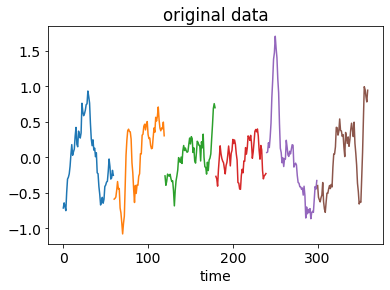

data:  10000


In [15]:
y_4XGB = categ #Defined during the first time we loaded data 
N,L = len(x), len(x[0])

show_data_strains(x,L,"original data", nsegments = 6)

# note: here it does not need to be converted to the 3-bit version, a label remains y[i]=0,1,2
n_class = 3    #  = len(np.unique(y))
print('data: ',N)

In [16]:
def get_df(x):
    '''Build input dataframe for given data series
    Input:
    var = array of time series, (#samples,time,1)
    Return:
    df = dataframe ready for features extraction
    '''
    
    #N = #samples, t = timesteps
    N, t = x.shape[0], x.shape[1]
    #build id columns
    id_col = np.repeat(np.arange(N),t)
    #build time columns
    time_col = np.tile(np.arange(t),N)
    #build var columns
    x_col = x.flatten()
      
    #build dict for df
    x_dict = {'id':id_col,'time':time_col,'value':x_col}
        
    #return dataframe
    return pd.DataFrame(x_dict)

df = get_df(x) 

#### Extract the relevant features

In [17]:
if do_compute_features:
    # compute the features
    x_features = extract_features(
                                df, #our dataframe
                                column_id='id', #sample id, from 0 to N
                                column_sort='time', #timestep, from 0 to t
                                column_kind=None, #we have only one feature
                                column_value='value', #value of input 
                                n_jobs=22) #number of cores
    
    # NaNs are replaced with zeros
    #x_features.replace([np.inf, -np.inf], np.nan)
    #x_features = np.nan_to_num(x_features)
    x_features_normalized = x_features/np.nanmean(x_features, axis = 0)
    x_features_normalized = x_features_normalized.fillna(0)
    x_features_normalized.to_csv(f"{folder_data}/timeseries_features_nonan.csv", index=False)
    x_features_backup = x_features_normalized # use the normalized values from now on

x_features = pd.read_csv(f"{folder_data}/timeseries_features_nonan.csv")
print(x_features.shape)

(10000, 789)


#### Create XGBoost model

In [18]:
#define parameters for xgboost
params = {'max_depth':6,'min_child_weight':1, 'learning_rate':0.3,'use_label_encoder':False}

#build model with given params
model_XGB = XGBClassifier(**params)

#### Train the XGBoost

In [19]:
perc_train=0.8
N_train = int(perc_train*N)
x_4XGB_train = x_features[:N_train]
y_4XGB_train = y_4XGB[:N_train]
x_4XGB_val = x_features[N_train:]
y_4XGB_val = y_4XGB[N_train:]
N_val = len(x_4XGB_val)

#rescale: in each feature, remove average and divide by std
if True:
    average = np.mean(x_4XGB_train,axis=0)
    x_4XGB_train -= average
    x_4XGB_val -= average

    std = np.std(x_4XGB_train,axis=0)
    x_4XGB_train /= std
    x_4XGB_val /= std


dataset_sizes = np.array([20, 50, 100, 150, 200, 250, 300, 400, 500])
XGB_fits_complete = []
print('-----\nFITTING....')

for i in range(0,9):
    XGB_fits = []

    for j in range (0,10):
        dataset_train_sizes = dataset_sizes*perc_train
        dataset_val_sizes = dataset_sizes*(1-perc_train)
        starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
        starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)
        #print(int(starting_point_train),int(starting_point_train+dataset_train_sizes[i]))

        x_train_reduced = x_4XGB_train[int(starting_point_train):int(starting_point_train+dataset_train_sizes[i])]
        x_val_reduced = x_4XGB_val[int(starting_point_val):int(starting_point_val+dataset_val_sizes[i])]
        y_train_reduced = y_4XGB_train[int(starting_point_train):int(starting_point_train+dataset_train_sizes[i])]
        y_val_reduced = y_4XGB_val[int(starting_point_val):int(starting_point_val+dataset_val_sizes[i])]


        model_XGB.fit(pd.DataFrame(x_train_reduced).values,y_train_reduced)

        y_4XGB_pred_train = model_XGB.predict(x_train_reduced)
        y_4XGB_pred_val = model_XGB.predict(x_val_reduced)
        y_4XGB_pred_val_soft = model_XGB.predict_proba(x_val_reduced)

        acc_train = accuracy_score(y_train_reduced,y_4XGB_pred_train) 
        acc_val = accuracy_score(y_val_reduced,y_4XGB_pred_val)

        XGB_fits.append([acc_train, acc_val])
    XGB_fits_complete.append(XGB_fits)

-----
FITTING....


/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7984.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1996.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:53:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7984.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1996.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:53:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7984.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1996.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:53:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7984.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1996.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:53:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7984.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1996.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:53:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7984.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1996.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:53:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7984.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1996.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:53:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7984.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1996.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:53:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7984.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1996.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:53:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7984.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1996.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:53:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7960.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1990.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:53:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7960.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1990.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:53:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7960.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1990.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:53:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7960.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1990.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:53:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7960.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1990.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:53:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7960.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1990.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:53:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7960.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1990.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:53:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7960.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1990.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:53:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7960.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1990.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:53:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7960.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1990.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:53:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7920.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1980.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7920.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1980.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7920.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1980.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7920.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1980.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7920.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1980.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7920.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1980.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7920.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1980.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7920.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1980.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7920.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1980.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7920.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1980.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7880.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1970.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7880.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1970.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7880.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1970.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7880.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1970.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7880.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1970.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7880.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1970.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7880.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1970.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7880.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1970.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7880.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1970.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7880.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1970.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7840.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1960.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7840.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1960.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7840.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1960.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7840.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1960.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7840.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1960.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7840.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1960.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7840.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1960.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7840.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1960.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7840.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1960.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7840.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1960.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7800.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1950.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7800.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1950.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7800.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1950.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7800.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1950.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7800.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1950.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7800.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1950.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7800.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1950.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7800.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1950.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7800.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1950.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7800.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1950.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7760.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1940.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7760.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1940.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7760.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1940.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7760.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1940.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7760.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1940.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7760.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1940.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7760.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1940.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7760.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1940.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7760.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1940.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7760.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1940.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7680.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1920.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7680.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1920.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7680.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1920.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7680.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1920.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7680.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1920.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7680.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1920.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7680.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1920.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7680.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1920.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7680.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1920.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7680.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1920.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7600.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1900.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7600.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1900.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7600.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1900.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7600.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1900.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7600.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1900.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7600.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1900.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7600.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1900.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7600.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1900.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7600.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1900.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_345903/1790895435.py:30: DeprecationWarning: This function is deprecated. Please call randint(1, 7600.0 + 1) instead
  starting_point_train =  random.random_integers(low = 1, high = (x_4XGB_train.shape[0]-dataset_train_sizes[i]), size=None)
/tmp/ipykernel_345903/1790895435.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1900.0 + 1) instead
  starting_point_val =  random.random_integers(low = 0, high = (x_4XGB_val.shape[0]-dataset_val_sizes[i]), size=None)


[14:54:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/baronefr/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [20]:
print(XGB_fits_complete)

[[[1.0, 0.5], [1.0, 0.75], [1.0, 0.75], [1.0, 0.5], [1.0, 1.0], [1.0, 0.75], [1.0, 0.5], [1.0, 0.5], [1.0, 0.5], [1.0, 0.5]], [[1.0, 0.9], [1.0, 0.9], [1.0, 0.8], [1.0, 1.0], [1.0, 0.9], [1.0, 0.9], [1.0, 0.4], [1.0, 0.9], [1.0, 0.7], [1.0, 0.6]], [[1.0, 0.7894736842105263], [1.0, 1.0], [1.0, 0.8], [1.0, 0.95], [1.0, 0.8], [1.0, 0.9], [1.0, 0.85], [1.0, 0.75], [1.0, 0.9], [1.0, 0.7]], [[1.0, 0.8666666666666667], [1.0, 0.9333333333333333], [1.0, 0.8666666666666667], [1.0, 0.8333333333333334], [1.0, 0.9], [1.0, 0.8666666666666667], [1.0, 0.9333333333333333], [1.0, 0.7333333333333333], [1.0, 0.8666666666666667], [1.0, 0.8666666666666667]], [[1.0, 0.875], [1.0, 0.875], [1.0, 0.925], [1.0, 0.95], [1.0, 0.95], [1.0, 0.875], [1.0, 0.925], [1.0, 0.95], [1.0, 0.925], [1.0, 0.95]], [[1.0, 0.86], [1.0, 0.94], [1.0, 0.94], [1.0, 0.92], [1.0, 0.8775510204081632], [1.0, 0.94], [1.0, 0.96], [1.0, 0.92], [1.0, 0.94], [1.0, 0.9]], [[1.0, 0.9333333333333333], [1.0, 0.8833333333333333], [1.0, 0.933333333

#### Creating a dataframe with the performances of the three models

In [21]:
basic_accuracies = np.mean(basic_model_fits_complete, axis=1)
global_accuracies = np.mean(global_pooling_fits_complete, axis=1)
XGB_accuracies = np.mean(XGB_fits_complete, axis=1)
basic_std = np.std(basic_model_fits_complete, axis=1)
global_std = np.std(global_pooling_fits_complete, axis=1)
XGB_std = np.std(XGB_fits_complete, axis=1)

In [22]:
compared_results = {
        'dataset dimension': np.array([20, 50, 100, 150, 200, 250, 300, 400, 500]),
        'train accuracy basic CNN': basic_accuracies[:,0],
        'valid accuracy basic CNN': basic_accuracies[:,1],
        'train stds basic CNN': basic_std[:,0],
        'valid stds basic CNN': basic_std[:,1],
        'train accuracy global pooling': global_accuracies[:,0],
        'valid accuracy global pooling': global_accuracies[:,1],
        'train stds global pooling': global_std[:,0],
        'valid stds global pooling': global_std[:,1],
        'train accuracy XGBoost': XGB_accuracies[:,0],
        'valid accuracy XGBoost': XGB_accuracies[:,1],
        'train stds XGBoost': XGB_std[:,0],
        'valid stds XGBoost': XGB_std[:,1],
        }
 
df_compared_results = pd.DataFrame(compared_results)
pd.options.display.float_format = '{:,.2f}'.format
#print(df_compared_results)

#### Comparing the performances

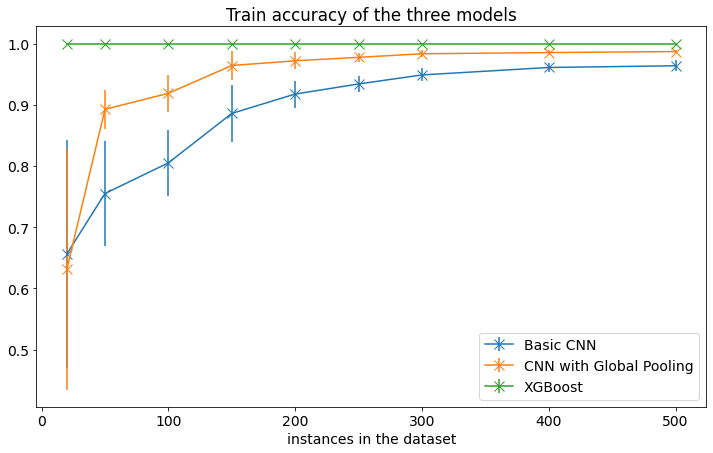

In [23]:
plt.figure(figsize=(12,7))
plt.errorbar(df_compared_results['dataset dimension'], df_compared_results['train accuracy basic CNN'], yerr=df_compared_results['train stds basic CNN'], label="Basic CNN", marker="x", markersize=10)
plt.errorbar(df_compared_results['dataset dimension'], df_compared_results['train accuracy global pooling'], yerr=df_compared_results['train stds global pooling'], label="CNN with Global Pooling", marker="x", markersize=10)
plt.errorbar(df_compared_results['dataset dimension'], df_compared_results['train accuracy XGBoost'], yerr=df_compared_results['train stds XGBoost'], label="XGBoost", marker="x", markersize=10)
plt.legend(loc='lower right')
plt.title("Train accuracy of the three models")
plt.xlabel("instances in the dataset")
plt.show()


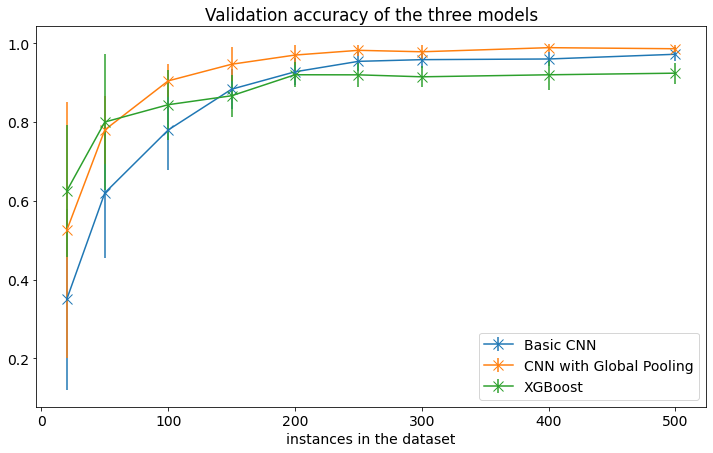

In [24]:
plt.figure(figsize=(12,7))
plt.errorbar(df_compared_results['dataset dimension'], df_compared_results['valid accuracy basic CNN'], yerr=df_compared_results['valid stds basic CNN'], label="Basic CNN", marker="x", markersize=10)
plt.errorbar(df_compared_results['dataset dimension'], df_compared_results['valid accuracy global pooling'], yerr=df_compared_results['valid stds global pooling'], label="CNN with Global Pooling", marker="x", markersize=10)
plt.errorbar(df_compared_results['dataset dimension'], df_compared_results['valid accuracy XGBoost'], yerr=df_compared_results['valid stds XGBoost'], label="XGBoost", marker="x", markersize=10)
plt.legend(loc='lower right')
plt.title("Validation accuracy of the three models")
plt.xlabel("instances in the dataset")
plt.show()

### Results
From the plots it is possible to see that the default  XGBoost model outperforms the convolutional neural networks (even the best model with global pooling) on the small datasets. On bigger datasets instead the neural networks perform better, in particular the one with global pooling.

In [60]:
if do_generate_data:
    np.savetxt(f'{folder_data}/timeseries_features_importances.txt',model_XGB.feature_importances_)

<a id='sec2'></a>
## **2** - feature selection & description

In [26]:
if not do_generate_data:
    x_features = pd.read_csv(f"{folder_data}/timeseries_features_nonan.csv")
    feature_names = x_features.columns.values

#empty dict
feat_imp = {}
#get f importance from model
for i,f in enumerate(feature_names):
    feat_imp[f] = model_XGB.feature_importances_[i]
#sort features depending on their importances
feat_imp = dict(sorted(feat_imp.items(), reverse=True, key=lambda item: item[1]))

#Change this value if result is bad
minval=0.015
print('------------- Feature importance sum = '+str(np.sum(model_XGB.feature_importances_)))
print('------------- Showing feature with importance > '+str(minval))
for i,k in enumerate(feat_imp.keys()):
    if feat_imp[k]>minval: print(i+1,k,feat_imp[k])

------------- Feature importance sum = 1.0
------------- Showing feature with importance > 0.015
1 value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0 0.1194755
2 value__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.076926835
3 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4 0.05775498
4 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6 0.035224073
5 value__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2 0.033647086
6 value__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0 0.032787457
7 value__fft_coefficient__attr_"imag"__coeff_3 0.027941948
8 value__cid_ce__normalize_False 0.02457159
9 value__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20) 0.022070015
10 value__autocorrelation__lag_8 0.019486628
11 value__fft_coefficient__attr_"angle"__coeff_2 0.016505372


In [27]:
len(model_XGB.feature_importances_)

789

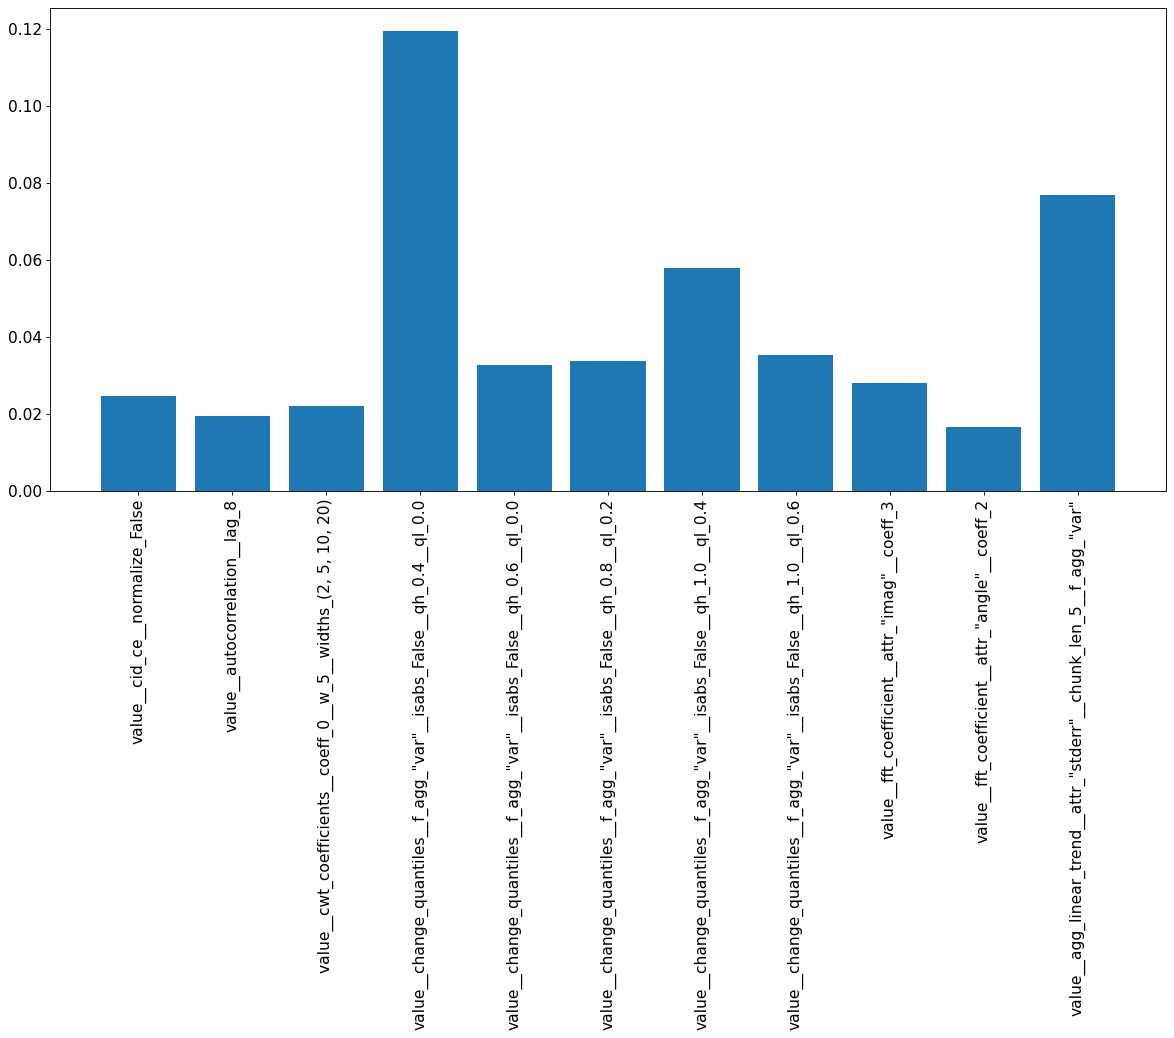

In [28]:
#print(model_XGB.feature_importances_)

sorted_idx = model_XGB.feature_importances_.argsort()
plt.figure(figsize=(18, 8), dpi=80)
plt.bar(feature_names[model_XGB.feature_importances_> minval],model_XGB.feature_importances_[model_XGB.feature_importances_> minval])
plt.xticks(rotation='vertical')
plt.show()

change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0 <br>
change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4<br>
change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0<br>
change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0<br>

This family of feature dominates the top of our most important features because it tries to get information about the variance of the dataset using a qh and ql as corridor variables to pick a corridor on the dataset and then it applies the function “var” shown in the description of the variable. Also in one of them isabs(True) is found, meaning that it is taking the absolute value of the differences in the dataset. This is crucial in our case because we need to see what patterns emerge in our dataset and how to recognize them.

cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)<br>
cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)

These functions calculate a Continuous wavelet transform for the Ricker wavelet, also known as the "Mexican hat wavelet". This feature calculator takes three different parameters: widths, coeff and “w”. The feature calculator takes all the different widths arrays and then calculates the cwt one time for each different width array. Then the values for the different coefficient for coeff and width “w” are returned. This is also useful for our case because the Ricker wavelet has a high resistance to noise and it can successfully recognize the principal features of our dataset.

change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4

Also, we have a “mean” corridor that extracts the mean of the absolute values of the dataset. This works like the “var” corridor but the average value of a section of the dataset is not so crucial to the training of the model as the variance and that’s why this parameter does not rank higher or appear multiple times.

fft_aggregated__aggtype_"variance" <br>
fft_coefficient__attr_"angle"__coeff_6 

Finally two parameters related to the fast fourier transform of the dataset are found. Aggregated returns the variance of the fourier transform meaning the difference between the many frequency components in the dataset. Coefficient returns the angle component of the fourier transform, meaning the phase of the signal in the frequency domain. These together bring valuable information about the frequency components of the datatset. Combined with the variance parameters it can describe the behaviour of the samples in a more accurate way.


### Save the features for the next part

In [29]:
minval=0.015
x_features_important = x_features.T[model_XGB.feature_importances_> minval]
x_features_important = x_features_important.T
x_features_important
if do_compute_features: 
    np.savetxt(f"{folder_data}/timeseries_selected_features_015.txt", x_features_important)

In [30]:
minval=0.010
x_features_important = x_features.T[model_XGB.feature_importances_> minval]
x_features_important = x_features_important.T
x_features_important
if do_compute_features:
    np.savetxt(f"{folder_data}/timeseries_selected_features_010.txt", x_features_important)

<a id='sec3'></a>
## **3** - FFNN vs XGBoost

With the features extracted by tsfresh, train a standard (non-convolutional) feed forward neural network (FFNN) and compare the performances with those of XGBoost. Than keep only the most relevant features from XGBoost and train another FFNN with this smaller set. Is the new FFNN working better than the one trained with all features?

In [31]:
# take the features
if not do_generate_data:
    x_features = pd.read_csv(f"{folder_data}/timeseries_features_nonan.csv")
    y_features = np.loadtxt(f"{folder_data}/y_ts_L60_Z12_A500_DX50_bias5_N10000.dat", dtype=int)

x_features = x_features.to_numpy()
data_strain_param = {'dim':1, 'Z':12, 'A':500, 'N':10000, 'L':60, 'DX':50, 'bias':5}

# take a look at the layout of data
(N, n_feats) = x_features.shape
print(f'{x_features.shape} -> {n_feats} features, {N} samples')
label_set = list(np.unique(y_features))
n_class = len(label_set)
print(f'categories {label_set} -> {n_class} categories')

# NaN management
print(f'\nthere are {np.sum(np.isnan(x_features))} NaN in the dataset (replacing them to zero)')
x_features = np.nan_to_num(x_features)

# using onehot encoding for output
y_onehot = np.zeros((N,n_class))
for i, y in enumerate(y_features):
    y_onehot[i][y] = 1

(10000, 789) -> 789 features, 10000 samples
categories [0, 1, 2] -> 3 categories

there are 0 NaN in the dataset (replacing them to zero)


In [32]:
perc_train = 0.8
N_train = int(perc_train*N)
x_train = x_features[:N_train]
y_train = y_onehot[:N_train]
x_valid = x_features[N_train:]
y_valid = y_onehot[N_train:]
N_valid = len(x_valid)
print(f' train {N_train}, validation {N_valid}')
print(len(x_train[0]))
print(x_train)

 train 8000, validation 2000
789
[[0.         0.         0.         ... 0.85077165 0.80906375 0.81884707]
 [0.         0.         0.         ... 0.67587631 0.62770725 0.8783678 ]
 [0.         0.         0.         ... 0.         0.         0.62170802]
 ...
 [0.         0.         0.         ... 0.         0.         0.90670225]
 [0.         0.         0.         ... 1.13234079 0.92978575 0.73673237]
 [0.         0.         0.         ... 0.         0.         0.96236533]]


In [33]:
def setup_ffnn_layout(activation, dropout_rate, layers, init):
    # this function defines the layout of the model
    model = Sequential()
    model.add(Dense(n_feats,input_dim=n_feats, activation = 'sigmoid', kernel_initializer=init))
    for i in range(len(layers)):
        model.add(Dense(layers[i], activation = activation, kernel_initializer=init))
    if dropout_rate != 0:  model.add(Dropout(dropout_rate))
    
    model.add(Dense(n_class,activation='softmax', kernel_initializer=init)) # softmax!
    return model
    

def create_ffnn_model(optimizer="Adam", activation = "relu", dropout_rate = 0.1, layers = (100, 100), init = 'glorot_uniform'):
    # create the model
    model = setup_ffnn_layout(activation, dropout_rate, layers, init)
    
    # compile the model
    #opt = tf.keras.optimizers.Adam()
    #loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False,
    #                                           label_smoothing=0.0,
    #                                           axis=-1,
    #                                           reduction="auto",
    #                                           name="categorical_crossentropy",)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [34]:
ffnn_params = {'activation':'softplus', 'dropout_rate':0.1, 'optimizer':'Adam', 'init':'glorot_normal'}  # paste here the model to use

model = create_ffnn_model(**ffnn_params, layers = (200,20))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 789)               623310    
                                                                 
 dense_4 (Dense)             (None, 200)               158000    
                                                                 
 dense_5 (Dense)             (None, 20)                4020      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_6 (Dense)             (None, 3)                 63        
                                                                 
Total params: 785,393
Trainable params: 785,393
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
fit = model.fit(x_train, y_train, epochs = 200, batch_size = 100,
                validation_data = (x_valid, y_valid), verbose = 2)

Epoch 1/200
80/80 - 0s - loss: 1.0583 - accuracy: 0.4551 - val_loss: 0.9099 - val_accuracy: 0.5900 - 383ms/epoch - 5ms/step
Epoch 2/200
80/80 - 0s - loss: 0.8117 - accuracy: 0.6294 - val_loss: 0.6924 - val_accuracy: 0.7095 - 161ms/epoch - 2ms/step
Epoch 3/200
80/80 - 0s - loss: 0.5979 - accuracy: 0.7508 - val_loss: 0.4916 - val_accuracy: 0.8185 - 166ms/epoch - 2ms/step
Epoch 4/200
80/80 - 0s - loss: 0.4746 - accuracy: 0.8210 - val_loss: 0.3963 - val_accuracy: 0.8605 - 165ms/epoch - 2ms/step
Epoch 5/200
80/80 - 0s - loss: 0.3680 - accuracy: 0.8605 - val_loss: 0.3430 - val_accuracy: 0.8635 - 171ms/epoch - 2ms/step
Epoch 6/200
80/80 - 0s - loss: 0.3146 - accuracy: 0.8839 - val_loss: 0.3319 - val_accuracy: 0.8770 - 165ms/epoch - 2ms/step
Epoch 7/200
80/80 - 0s - loss: 0.3031 - accuracy: 0.8829 - val_loss: 0.3270 - val_accuracy: 0.8745 - 173ms/epoch - 2ms/step
Epoch 8/200
80/80 - 0s - loss: 0.2612 - accuracy: 0.9056 - val_loss: 0.2838 - val_accuracy: 0.8965 - 166ms/epoch - 2ms/step
Epoch 9/

#### results of the model trained on the whole set of features

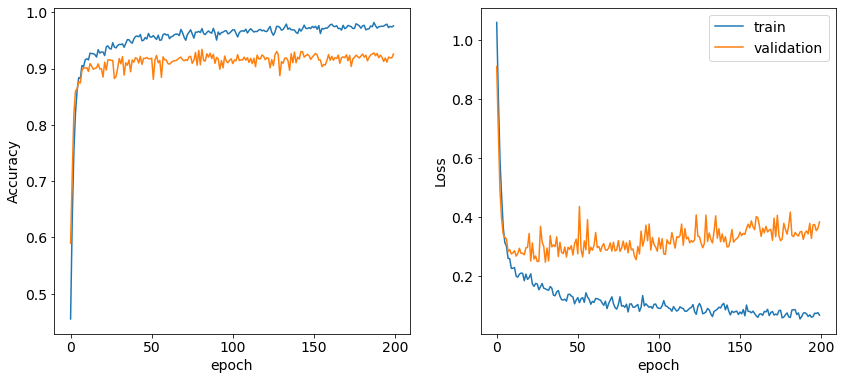

In [36]:
%run utils_ffnn.py
ax = plot_fit_train_loss(fit)
if savefigs: plt.savefig(f'./{folder_img}/ffnn_model_loss_features_all.pdf')

<a id='sec3_01'></a>
### FFNN on selected features (11 features, 98.5% variance)

In [37]:
# take the features
x_features = np.loadtxt(f"{folder_data}/timeseries_selected_features_015.txt")
y_features = np.loadtxt(f"{folder_data}/y_ts_L60_Z12_A500_DX50_bias5_N10000.dat", dtype=int)

data_strain_param = {'dim':1, 'Z':12, 'A':500, 'N':10000, 'L':60, 'DX':50, 'bias':5}

# take a look at the layout of data
(N, n_feats) = x_features.shape
print(f'{x_features.shape} -> {n_feats} features, {N} samples')
label_set = list(np.unique(y_features))
n_class = len(label_set)
print(f'categories {label_set} -> {n_class} categories')

# NaN management
print(f'\nthere are {np.sum(np.isnan(x_features))} NaN in the dataset (replacing them to zero)')
x_features = np.nan_to_num(x_features)

# using onehot encoding for output
y_onehot = np.zeros((N,n_class))
for i, y in enumerate(y_features):
    y_onehot[i][y] = 1
    
#rescaling - in each feature, remove average and divide by std
if True:
    average = np.mean(x_features,axis=0)
    x_features -= average
    std = np.std(x_features,axis=0)
    x_features /= std
    
perc_train = 0.8
N_train = int(perc_train*N)
x_train = x_features[:N_train]
y_train = y_onehot[:N_train]
x_valid = x_features[N_train:]
y_valid = y_onehot[N_train:]
N_valid = len(x_valid)
print(f' train {N_train}, validation {N_valid}')
print(len(x_train[0]))

(10000, 11) -> 11 features, 10000 samples
categories [0, 1, 2] -> 3 categories

there are 0 NaN in the dataset (replacing them to zero)
 train 8000, validation 2000
11


In [38]:
def setup_ffnn_layout(activation, dropout_rate, layers, init):
    # this function defines the layout of the model
    model = Sequential()
    model.add(Dense(n_feats,input_dim=n_feats, activation = 'sigmoid', kernel_initializer=init))
    model.add(Dense(layers[0], activation = 'softplus', kernel_initializer=init))
    if dropout_rate != 0:  model.add(Dropout(dropout_rate))
    model.add(Dense(layers[1], activation = 'relu', kernel_initializer=init))

    model.add(Dense(n_class,activation='softmax', kernel_initializer=init)) # softmax!
    return model

def create_ffnn_model(optimizer="Adam", activation = "relu", dropout_rate = 0.0, layers = (100, 100), init = 'glorot_uniform'):
    # create the model
    model = setup_ffnn_layout(activation, dropout_rate, layers, init)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [39]:
ffnn_params = {'activation':'softplus', 'dropout_rate':0.1, 'optimizer':'Nadam'}  # paste here the model to use
model = create_ffnn_model(**ffnn_params, layers = (20,10))
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 11)                132       
                                                                 
 dense_8 (Dense)             (None, 20)                240       
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_9 (Dense)             (None, 10)                210       
                                                                 
 dense_10 (Dense)            (None, 3)                 33        
                                                                 
Total params: 615
Trainable params: 615
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
fit = model.fit(x_train, y_train, epochs = 200, batch_size = 100,
                validation_data = (x_valid, y_valid), verbose = 2)

Epoch 1/200
80/80 - 0s - loss: 1.1115 - accuracy: 0.4026 - val_loss: 1.0197 - val_accuracy: 0.7315 - 441ms/epoch - 6ms/step
Epoch 2/200
80/80 - 0s - loss: 0.9536 - accuracy: 0.6231 - val_loss: 0.7994 - val_accuracy: 0.8145 - 61ms/epoch - 763us/step
Epoch 3/200
80/80 - 0s - loss: 0.7035 - accuracy: 0.7602 - val_loss: 0.5222 - val_accuracy: 0.8415 - 53ms/epoch - 660us/step
Epoch 4/200
80/80 - 0s - loss: 0.5142 - accuracy: 0.8058 - val_loss: 0.3931 - val_accuracy: 0.8555 - 57ms/epoch - 710us/step
Epoch 5/200
80/80 - 0s - loss: 0.4366 - accuracy: 0.8236 - val_loss: 0.3524 - val_accuracy: 0.8615 - 55ms/epoch - 686us/step
Epoch 6/200
80/80 - 0s - loss: 0.4051 - accuracy: 0.8366 - val_loss: 0.3349 - val_accuracy: 0.8655 - 55ms/epoch - 686us/step
Epoch 7/200
80/80 - 0s - loss: 0.3931 - accuracy: 0.8404 - val_loss: 0.3270 - val_accuracy: 0.8660 - 50ms/epoch - 624us/step
Epoch 8/200
80/80 - 0s - loss: 0.3771 - accuracy: 0.8493 - val_loss: 0.3233 - val_accuracy: 0.8680 - 56ms/epoch - 699us/step
E

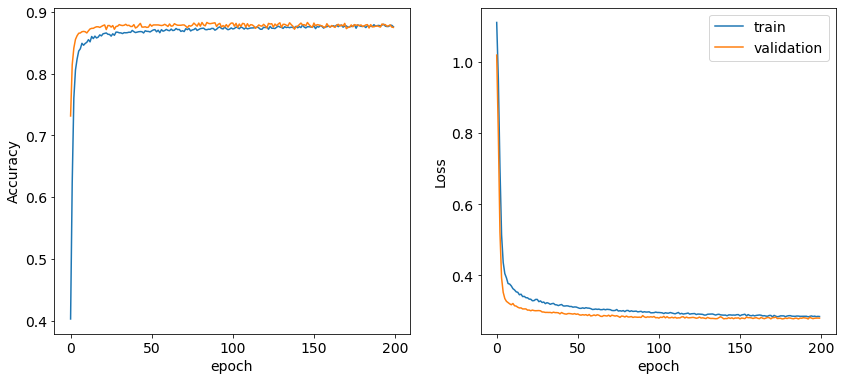

In [41]:
%run utils_ffnn.py
ax = plot_fit_train_loss(fit)
if savefigs: plt.savefig(f'./{folder_img}/ffnn_model_loss_selected_features_{n_feats}.pdf')

<a id='sec3_02'></a>
### FFNN on selected features (19 features, 99% variance)

In [42]:
# take the features
x_features = np.loadtxt(f"{folder_data}/timeseries_selected_features_010.txt")
y_features = np.loadtxt(f"{folder_data}/y_ts_L60_Z12_A500_DX50_bias5_N10000.dat", dtype=int)
data_strain_param = {'dim':1, 'Z':12, 'A':500, 'N':10000, 'L':60, 'DX':50, 'bias':5}

# take a look at the layout of data
(N, n_feats) = x_features.shape
print(f'{x_features.shape} -> {n_feats} features, {N} samples')
label_set = list(np.unique(y_features))
n_class = len(label_set)
print(f'categories {label_set} -> {n_class} categories')

# NaN management
print(f'\nthere are {np.sum(np.isnan(x_features))} NaN in the dataset (replacing them to zero)')
x_features = np.nan_to_num(x_features)

# using onehot encoding for output
y_onehot = np.zeros((N,n_class))
for i, y in enumerate(y_features):
    y_onehot[i][y] = 1
    
#rescaling - in each feature, remove average and divide by std
if True:
    average = np.mean(x_features,axis=0)
    x_features -= average
    std = np.std(x_features,axis=0)
    x_features /= std
    
perc_train = 0.8
N_train = int(perc_train*N)
x_train = x_features[:N_train]
y_train = y_onehot[:N_train]
x_valid = x_features[N_train:]
y_valid = y_onehot[N_train:]
N_valid = len(x_valid)
print(f' train {N_train}, validation {N_valid}')
print(len(x_train[0]))

(10000, 19) -> 19 features, 10000 samples
categories [0, 1, 2] -> 3 categories

there are 0 NaN in the dataset (replacing them to zero)
 train 8000, validation 2000
19


In [43]:
ffnn_params = {'activation':'softplus', 'dropout_rate':0.1, 'optimizer':'Nadam'}  # paste here the model to use
model = create_ffnn_model(**ffnn_params, layers = (20,10))
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 19)                380       
                                                                 
 dense_12 (Dense)            (None, 20)                400       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_13 (Dense)            (None, 10)                210       
                                                                 
 dense_14 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,023
Trainable params: 1,023
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
fit = model.fit(x_train, y_train, epochs = 200, batch_size = 100,
                validation_data = (x_valid, y_valid), verbose = 2)

Epoch 1/200
80/80 - 0s - loss: 1.0288 - accuracy: 0.4885 - val_loss: 0.8228 - val_accuracy: 0.7845 - 425ms/epoch - 5ms/step
Epoch 2/200
80/80 - 0s - loss: 0.6971 - accuracy: 0.7274 - val_loss: 0.5123 - val_accuracy: 0.8485 - 62ms/epoch - 777us/step
Epoch 3/200
80/80 - 0s - loss: 0.4743 - accuracy: 0.8189 - val_loss: 0.3237 - val_accuracy: 0.8790 - 55ms/epoch - 689us/step
Epoch 4/200
80/80 - 0s - loss: 0.3568 - accuracy: 0.8654 - val_loss: 0.2663 - val_accuracy: 0.8930 - 52ms/epoch - 645us/step
Epoch 5/200
80/80 - 0s - loss: 0.3162 - accuracy: 0.8744 - val_loss: 0.2495 - val_accuracy: 0.8960 - 58ms/epoch - 731us/step
Epoch 6/200
80/80 - 0s - loss: 0.3019 - accuracy: 0.8820 - val_loss: 0.2438 - val_accuracy: 0.9035 - 54ms/epoch - 672us/step
Epoch 7/200
80/80 - 0s - loss: 0.2887 - accuracy: 0.8863 - val_loss: 0.2367 - val_accuracy: 0.9055 - 60ms/epoch - 753us/step
Epoch 8/200
80/80 - 0s - loss: 0.2780 - accuracy: 0.8924 - val_loss: 0.2347 - val_accuracy: 0.9095 - 53ms/epoch - 665us/step
E

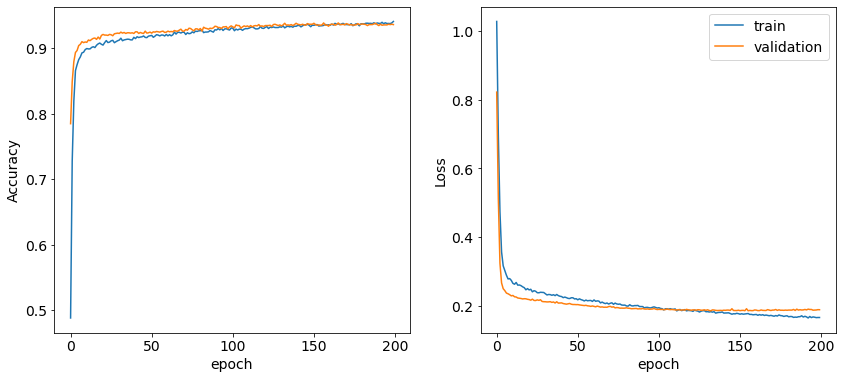

In [45]:
%run utils_ffnn.py
ax = plot_fit_train_loss(fit)
if savefigs: plt.savefig(f'./{folder_img}/ffnn_model_loss_selected_features_{n_feats}.pdf')

<a id='sec3_res'></a>
### Results

The FFNN trained on the whole dataset of features reaches an overall validation accuracy of $92\%$. However, such model requires a large amount of parameters (two layers of 200 & 20 neurons). If we look at the training process, we can see that the train accuracy improves, while the validation accuracy is stationary around 90%. This fact, along with the observation that the loss function on the validation set does not improve, prompts a situation of overfitting.

Reducing the dataset to the 19 features which account for $99\%$ of variance in the data, instead, allows to crucially reduce the size of the layers (20 + 10 neurons), reaching at the same time an accuracy of $\sim 93\%$.

<a id='sec4'></a>
## **4** - XGBoost hyperparameter tuning with GridSearchCV

In this section, binary classification of two-dimensional data using XGBoost is performed. The aim is to find the simplest yet effective XGBoost binary classification model that keeps a good accuracy.

### Generate data

--- available functions ---
triangle
baiesi_second
N_sphere
hollow_N_sphere
multi_sphere
polyhedron
hollow_polyhedron
multi_polyhedron
sine_surface
chessboard
mixed_chessboard


<module 'matplotlib.pyplot' from '/home/baronefr/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

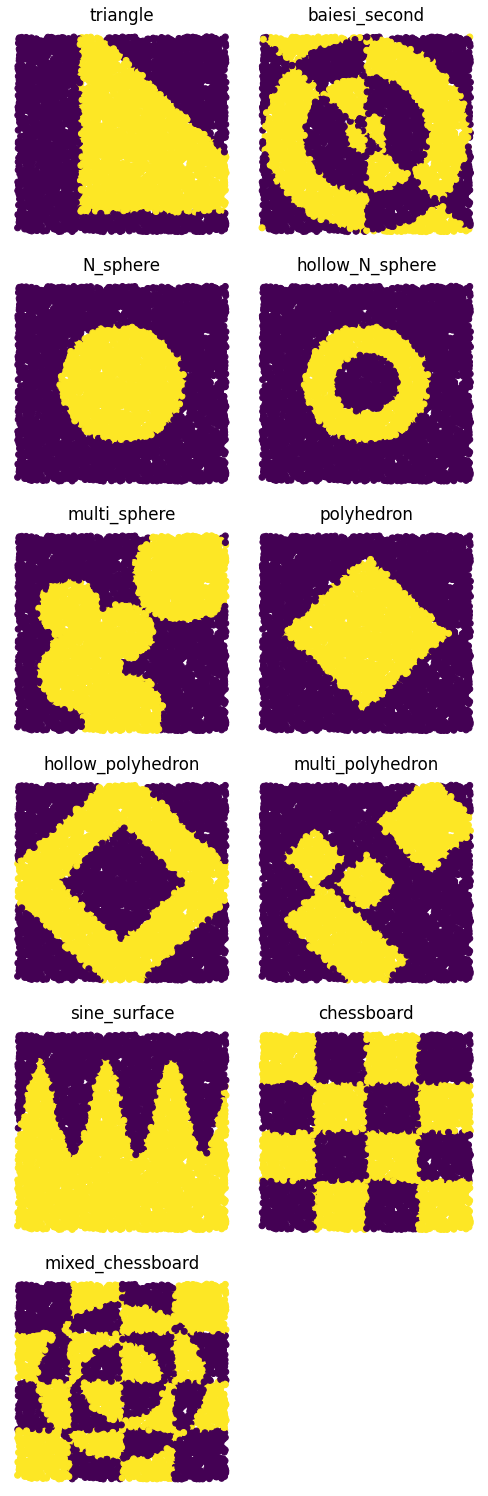

In [46]:
# import user-defined 2D functions
%run 2d_functions_collection.py
print_available_functions()
plot_available_functions()

In [47]:
# select a sample 2D function 
f_index = 1
f_name = available_functions_names[f_index]
print(f'Name of the selected function: "{f_name}"')

Name of the selected function: "baiesi_second"


In [48]:
np.random.seed(123)

dim = 2 # data dimensionality
N = 2000 # number of samples

low = -50
high = 50
x = np.random.uniform(low, high, size=(N,dim))

y = np.zeros(N)
for i in range(N):
    y[i] = f2d(f_index, x[i]) # label data according to the selected 2D function

### Split data in training set and test set

In [49]:
N_train = int(0.7*N) # number of samples in training set

x_train, y_train = x[:N_train], y[:N_train]
x_test,  y_test  = x[N_train:], y[N_train:]

print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)

x_train.shape = (1400, 2)
y_train.shape = (1400,)
x_test.shape = (600, 2)
y_test.shape = (600,)


### Plot data

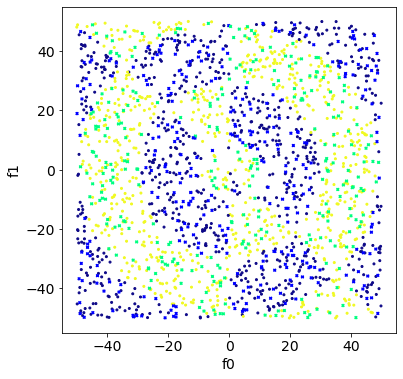

In [50]:
def scat(x, y, s=4, cmap="plasma", marker='o'):
    plt.scatter(x=x[:,0], y=x[:,1], s=s, c=y, marker=marker, cmap=cmap)
    plt.xlabel("f0")
    plt.ylabel("f1")

plt.figure(figsize=(6,6))
scat(x_train, y_train)
scat(x_test, y_test, s=7, cmap="winter", marker='x')
plt.show()

### Define the function that performs the classification and processes the results 

In [51]:
def classify(clf=GradientBoostingClassifier(), show=False):

    clf.fit(x_train, y_train)
    y_hat = clf.predict(x_test)

    print("Training error: {:.2f}%".format(100*(1-clf.score(x_train, y_train))))
    print("Test error: {:.2f}%".format(100*(1-clf.score(x_test, y_test))))

    dx = (high-low)/200
    x_seq = np.arange(low, high+dx, dx)

    nx = len(x_seq)
    x_plot = np.zeros((nx*nx,2))
    q = 0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:] = [x_seq[i],x_seq[j]]
            q += 1
    y_plot = clf.predict(x_plot)

    plt.figure(figsize=(6,6))
    plt.title(str(clf))

    scat(x_plot, y_plot, s=1, cmap="winter")
    scat(x_train, y_train, s=7)
    plt.show()
    
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("Number of trees:", num_trees)
        
        fig, AX = plt.subplots(3, 1, figsize=(30,30))
        for i in range(min(3, num_trees)):
            plot_tree(clf, num_trees=i, ax=AX[i])
        !mkdir img -p
        if savefigs: fig.savefig(f"{folder_img}/tree-classif.png", dpi=300, pad_inches=0.02)   
        plt.show()

### Define and fit the benchmark XGBClassifier model (the one used during the lesson)

Training error: 8.21%
Test error: 14.33%


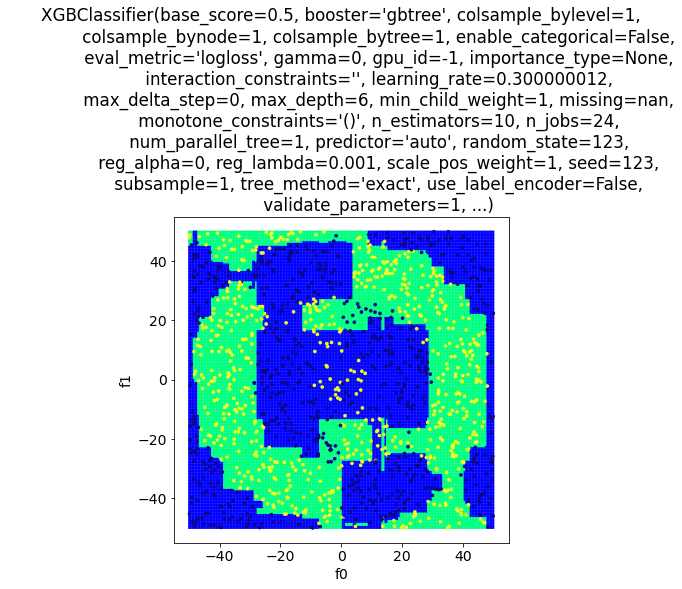

Number of trees: 10


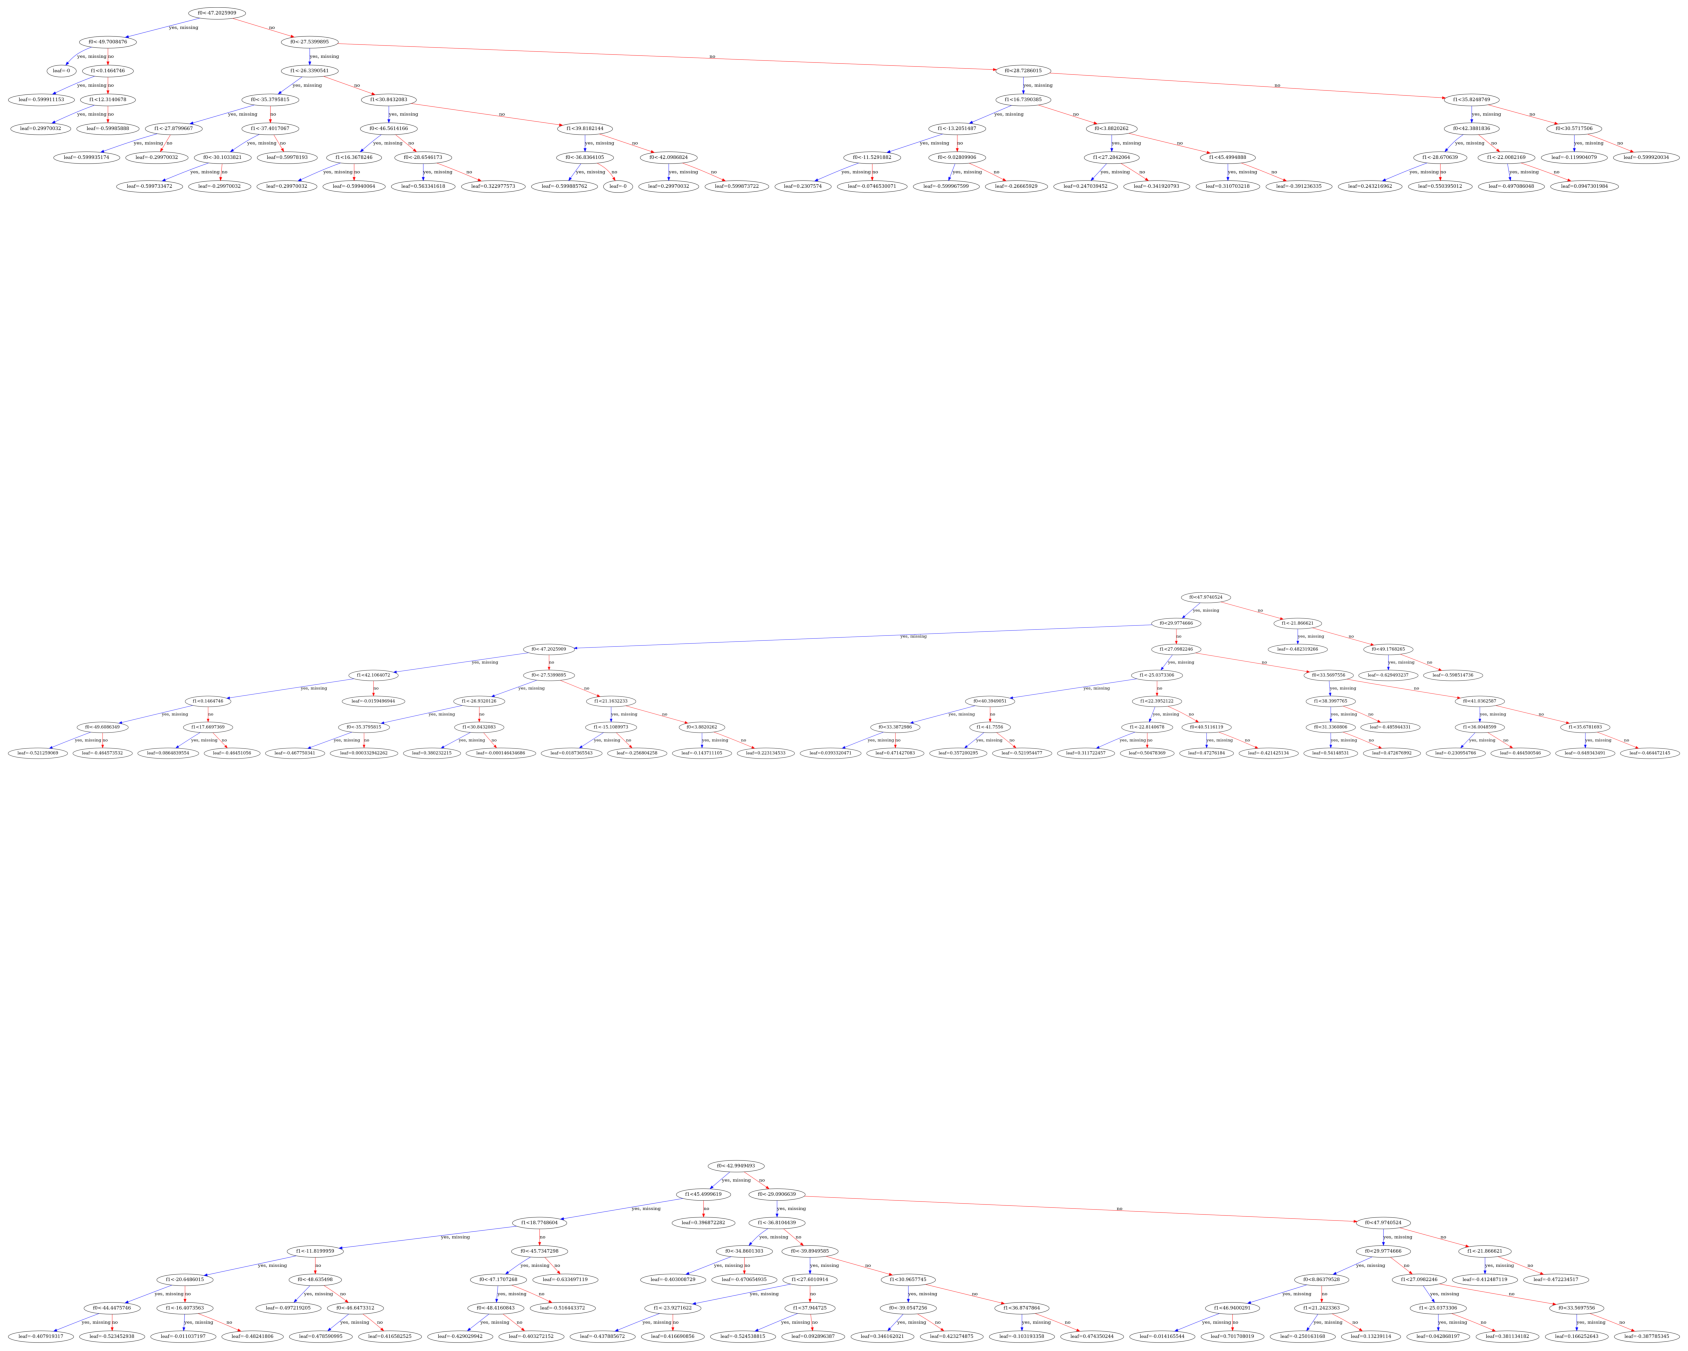

In [52]:
xgbc = XGBClassifier(
                    seed=123, # reproducibility
                    objective='binary:logistic',
                    reg_lambda=0.001,
                    n_estimators=10,
                    use_label_encoder=False,
                    eval_metric='logloss'
                    )

classify(xgbc, show=True)

### Perform a grid search to find the best XGBClassifier model

In [53]:
results_fname = f'{folder_data}/cv_results.csv'               # the results of the grid search will be saved to this .csv file
best_estimator_fname = f'{folder_data}/best_estimator.joblib' # the best model will be saved to this .joblib file

In [ ]:
if do_gridsearch:

    # import user-defined grid search function
    %run grid_search.py

    from xgboost import XGBClassifier

    s = 1 # step by which the XGBoost hyperparameters are explored

    param_grid = {# https://xgboost.readthedocs.io/en/stable/parameter.html
                'learning_rate'   :[i/100 for i in range(1,8,2*s)]+[i/10 for i in range(1,8,s)], # default=0.3, range:[0,1]
                                                                                                 # step size shrinkage used in update to prevent overfitting
                
                'gamma'           :[0]+[10**i for i in range(-6,-1,s)], # default=0, range:[0,+inf]
                                                                        # minimum loss reduction required to make a further partition on a leaf node of the tree
                                                                        # the larger gamma is, the more conservative the algorithm will be
                
                'max_depth'       :range(3,7,s), # default=6, range:[0,+inf]
                                                 # maximum depth of a tree, increasing this value will make the model more complex and more likely to overfit

                'min_child_weight':range(1,4,s), # default=1, range:[0,+inf]
                                                 # minimum sum of instance weight (hessian) needed in a child
                                                 # the larger min_child_weight is, the more conservative the algorithm will be

                'subsample'       :[i/10 for i in range(5,11,s)], # default=1, range:(0,1]
                                                                  # subsample ratio of the training instances (aim: prevent overfitting)
                                                                  # subsampling will occur once in every boosting iteration

                'reg_lambda'      :[10**i for i in range(-4,1,s)], # default=1
                                                                   # L2 regularization term on weights, increasing this value will make model more conservative

                #'reg_alpha'       :[0]+[(2**i)/10 for i in range(0,5,s)], # default=0
                                                                          # L1 regularization term on weights, increasing this value will make model more conservative
    }

    estimator = XGBClassifier(
                            # general parameters
                            n_estimators=10, # int, default=100
                                             # number of gradient boosted trees, equivalent to number of boosting rounds
                                             # if n_estimators=1, it means only 1 tree is generated, thus no boosting is at work

                            booster='gbtree', # 'gbtree' and 'dart' use tree based models while 'gblinear' uses linear functions

                            nthread=None, # number of parallel threads used to run XGBoost

                            use_label_encoder=False,

                            # booster parameters
                            tree_method='hist', # default='auto'
                                                # tree construction algorithm used in XGBoost
                                                # 'auto'    : use heuristic to choose the fastest method
                                                # 'exact'   : exact greedy algorithm, numerates all split candidates
                                                # 'approx'  : approximate greedy algorithm using quantile sketch and gradient histogram
                                                # 'hist'    : faster histogram optimized approximate greedy algorithm
                                                # 'gpu_hist': GPU implementation of hist algorithm

                            grow_policy='lossguide', # default='depthwise'
                                                     # controls a way new nodes are added to the tree, currently supported only if tree_method is set to 'hist' or 'gpu_hist'
                                                     # 'depthwise': split at nodes closest to the root
                                                     # 'lossguide': split at nodes with highest loss change
                                    
                            # learning task parameters
                            objective='binary:logistic', # 'binary:logistic': logistic regression for binary classification, output: probabilities
                                                         # 'binary:hinge'   : hinge loss for binary classification,          output: predictions of 0 or 1
                            
                            eval_metric='logloss', # default=('rmse' for regression, 'logloss' for classification, 'map' for ranking)
                                                   # evaluation metrics for validation data

                            seed=123, # reproducibility
                            )

    cv_results, xgbc_best = grid_search(X_train=x_train, y_train=y_train,
                                        X_test=x_test,   y_test=y_test, 
                
                                        estimator=estimator, param_grid=param_grid, scoring=None,
                                        n_jobs=None,         cv=4,                  verbose=1,

                                        results_save=True,        results_fname=results_fname, 
                                        best_estimator_save=True, best_estimator_fname=best_estimator_fname)

+--------------------------------------+
| sklearn.model_selection.GridSearchCV |
+--------------------------------------+
Fitting the estimator...
Fitting 4 folds for each of 23760 candidates, totalling 95040 fits
Done!
The results of the grid search have been saved to "cv_results.csv".
The best model has been saved to "best_estimator.joblib".

Best estimator:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints='', learning_rate=0.7, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=6, nthread=6,
              num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
        

### Load the results of the grid search from file

In [55]:
if not do_gridsearch:
    cv_results = pd.read_csv(results_fname)
    
cv_results = cv_results.sort_values(by=['rank_test_score'])
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
11819           0.02          0.00             0.00            0.00   
19739           0.02          0.00             0.00            0.00   
15779           0.02          0.00             0.00            0.00   
7859            0.02          0.00             0.00            0.00   
3899            0.01          0.00             0.00            0.00   
...              ...           ...              ...             ...   
65              0.01          0.00             0.00            0.00   
15911           0.01          0.00             0.00            0.00   
15905           0.01          0.00             0.00            0.00   
19877           0.01          0.00             0.00            0.00   
11957           0.01          0.00             0.00            0.00   

       param_gamma  param_learning_rate  param_max_depth  \
11819         0.00                 0.70                6   
19739         0.00                 0.70                6   
15779         0.00                 0.70                6   
7859          0.00                 0.70                6   
3899          0.00                 0.70                6   
...            ...                  ...              ...   
65            0.00                 0.01                3   
15911         0.00                 0.01                3   
15905         0.00                 0.01                3   
19877         0.01                 0.01                3   
11957         0.00                 0.01                3   

       param_min_child_weight  param_reg_lambda  param_subsample  \
11819                       1              1.00             1.00   
19739                       1              1.00             1.00   
15779                       1              1.00             1.00   
7859                        1              1.00             1.00   
3899                        1              1.00             1.00   
...                       ...               ...              ...   
65                          3              0.00             1.00   
15911                       3              0.00             1.00   
15905                       3              0.00             1.00   
19877                       3              0.01             1.00   
11957                       3              0.01             1.00   

                                                  params  split0_test_score  \
11819  {'gamma': 1e-05, 'learning_rate': 0.7, 'max_de...               0.90   
19739  {'gamma': 0.001, 'learning_rate': 0.7, 'max_de...               0.90   
15779  {'gamma': 0.0001, 'learning_rate': 0.7, 'max_d...               0.90   
7859   {'gamma': 1e-06, 'learning_rate': 0.7, 'max_de...               0.90   
3899   {'gamma': 0, 'learning_rate': 0.7, 'max_depth'...               0.90   
...                                                  ...                ...   
65     {'gamma': 0, 'learning_rate': 0.01, 'max_depth...               0.62   
15911  {'gamma': 0.001, 'learning_rate': 0.01, 'max_d...               0.62   
15905  {'gamma': 0.001, 'learning_rate': 0.01, 'max_d...               0.62   
19877  {'gamma': 0.01, 'learning_rate': 0.01, 'max_de...               0.62   
11957  {'gamma': 0.0001, 'learning_rate': 0.01, 'max_...               0.62   

       split1_test_score  split2_test_score  split3_test_score  \
11819               0.91               0.94               0.88   
19739               0.91               0.94               0.88   
15779               0.91               0.94               0.88   
7859                0.91               0.94               0.88   
3899                0.91               0.94               0.88   
...                  ...                ...                ...   
65                  0.63               0.61               0.65   
15911               0.63               0.61               0.65   
15905               0.63               0.61               0.65   
19877  

### Load the best XGBClassifier model from file

In [56]:
if not do_gridsearch:
    from joblib import load
    xgbc_best = load(best_estimator_fname)
    
print('Best XGBClassifier model:\n', xgbc_best)

Best XGBClassifier model:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints='', learning_rate=0.7, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=6, nthread=6,
              num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
              subsample=1.0, tree_method='hist', ...)


### Fit the best XGBClassifier model

Training error: 1.07%
Test error: 8.83%


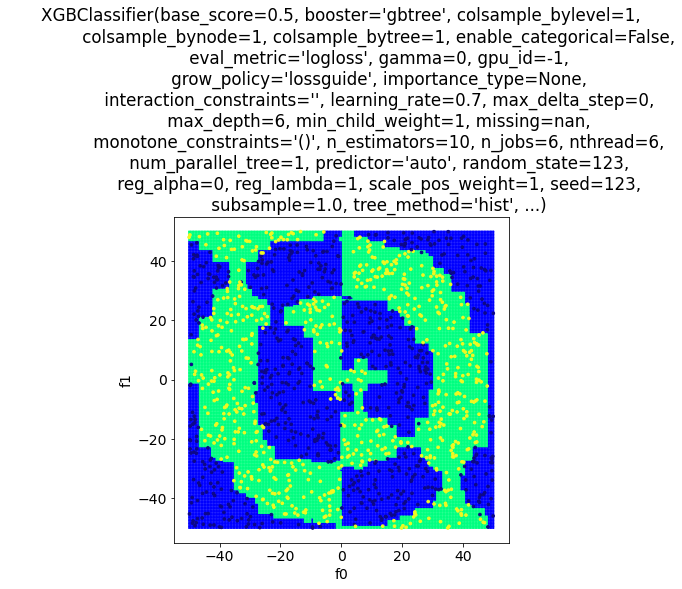

Number of trees: 10


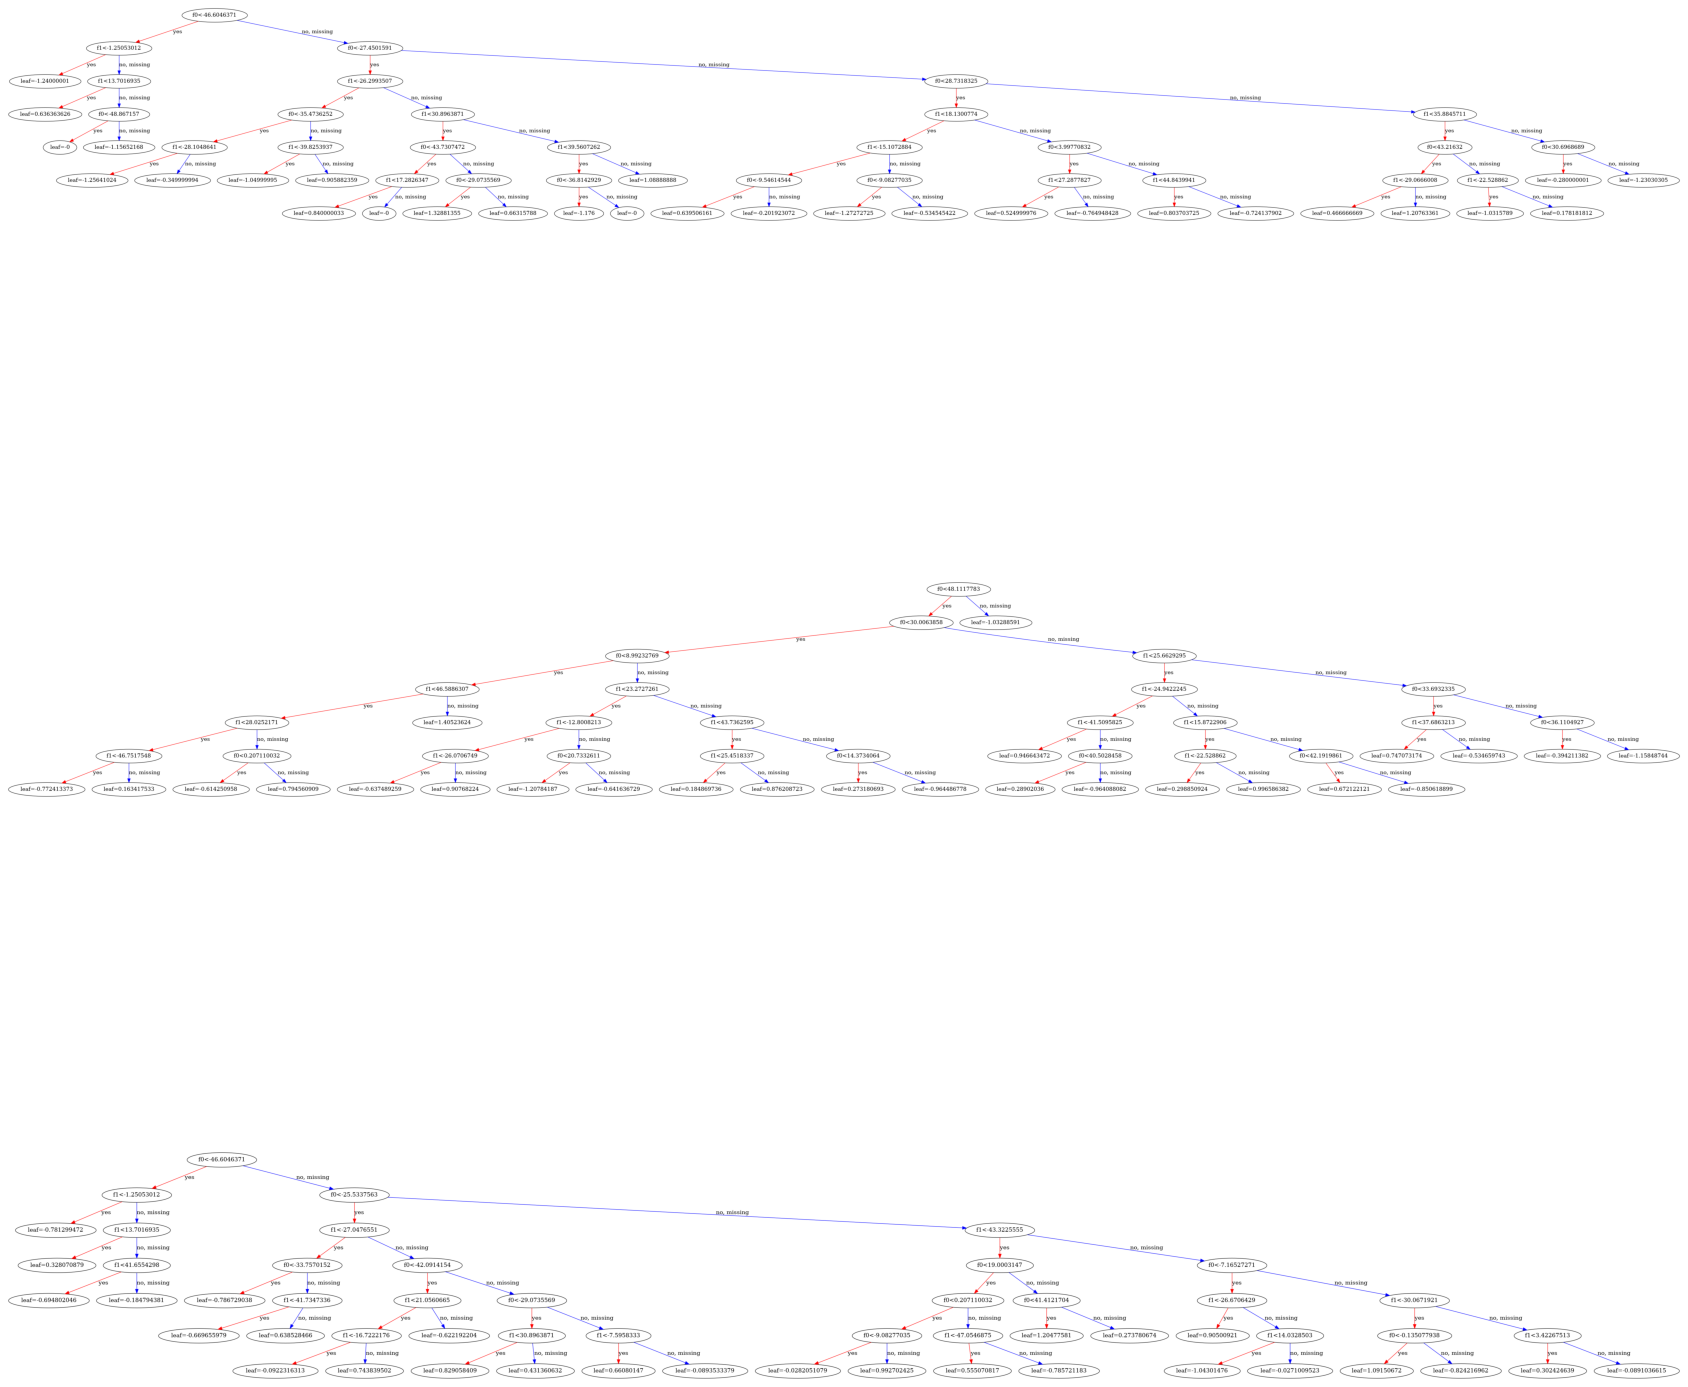

In [57]:
classify(xgbc_best, show=True)

### Comparison with other classification models

- #### GradientBoostingClassifier

Training error: 12.29%
Test error: 20.00%


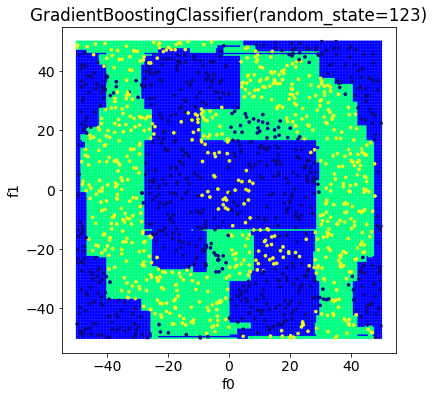

In [58]:
classify(clf=GradientBoostingClassifier(random_state=123))

- #### AdaBoostClassifier

Training error: 29.21%
Test error: 33.67%


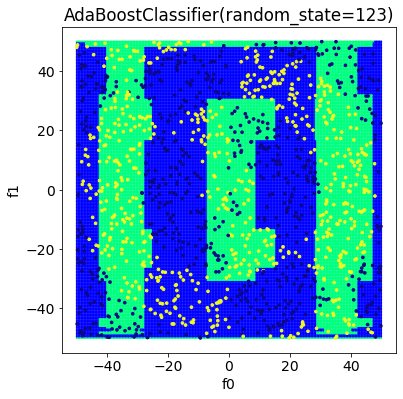

In [59]:
classify(clf=AdaBoostClassifier(random_state=123))

<a id='sec4_01'></a>
### Results

| Classifier | Training error (%) | Test error (%) |
| :-: | :-: | :-: |
| benchmark XGB    |  8.21 | 14.33 |
| best XGB         |  1.07 |  8.83 |
| GradientBoosting | 12.29 | 20.00 |
| AdaBoost         | 29.21 | 33.67 |

It is observed that, for the same number of trees (equal to 10), *best XGB* performs better than *benchmark XGB*. In particular, *best XGB* is characterized by a significantly lower test error.

Moreover, *best XGB* performs much better than both *GradientBoosting* and *AdaBoost*.

Therefore, as known, hyperparameter tuning is confirmed to be one of the most important steps in the configuration of any learning algorithm.

End of file.